In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import scipy.io as sio

In [2]:
data = sio.loadmat('../data/external/LVsVersusSubtendedAngle.mat')

In [3]:
clean_dict = {'lv': np.squeeze(data['LVs']), 'resp_angle': np.squeeze(data['subtendedAngleAtResponse'])}
df = pd.DataFrame(clean_dict)
df.describe()

lv  resp_angle
count  246.000000  246.000000
mean     0.694752   43.558036
std      0.308021   27.765487
min      0.100000   14.290141
25%      0.451914   28.034274
50%      0.714518   34.141328
75%      0.971854   46.764871
max      1.195086  169.885266

In [11]:
import os
gendata_path = '../data/generated/'
if not os.path.exists(gendata_path):
    os.makedirs(gendata_path)

df.to_hdf('../data/generated/pandas_test', key='experimental_data', mode='w')

other_df = pd.DataFrame({'a':np.arange(5)})
other_df.to_hdf('../data/generated/pandas_test', key='ground_truth', mode='a')

In [14]:
loaded_df = pd.read_hdf('../data/generated/pandas_test', key='experimental_data')
loaded_other_df = pd.read_hdf('../data/generated/pandas_test', key='ground_truth')

In [13]:
loaded_df.describe()

lv  resp_angle
count  246.000000  246.000000
mean     0.694752   43.558036
std      0.308021   27.765487
min      0.100000   14.290141
25%      0.451914   28.034274
50%      0.714518   34.141328
75%      0.971854   46.764871
max      1.195086  169.885266

In [15]:
loaded_other_df.describe()

a
count  5.000000
mean   2.000000
std    1.581139
min    0.000000
25%    1.000000
50%    2.000000
75%    3.000000
max    4.000000

In [16]:
import delfi
from delfi.simulator import GaussMixture
from delfi.simulator.BaseSimulator import BaseSimulator
from delfi.inference import SNPE
from delfi.inference import Basic
import delfi.distribution as dd
from delfi.summarystats import Identity
from delfi.generator import Default
from delfi.generator import MPGenerator
from delfi.utils import viz

import models as md

In [17]:
class LIF(BaseSimulator):
    def __init__(self, dim=1, seed=None, fixed_params=None):
        """Leaky Integrate-and-Fire simulator
        Integrates input until a given threshold is reached at which we
        define the response time.
        Parameters
        ----------
        dim : int
            Number of dimensions of parameters
        noise_cov : list
            Covariance of noise on observations
        seed : int or None
            If set, randomness is seeded
        """
        super().__init__(dim_param=dim, seed=seed)
        self.fixed_params = fixed_params

    @copy_ancestor_docstring
    def gen_single(self, param):
        # See BaseSimulator for docstring
        param = np.asarray(param).reshape(-1)
        assert param.ndim == 1
        assert param.shape[0] == self.dim_param

        model_params = self.fixed_params.copy()
        model_params['m'] = param[0]
        model_params['noise_std'] = param[1]*1e-3
        #model_params['vt_std'] = param[2]*1e-3
        nruns = 246
        rstims = np.zeros((1, nruns))
        lvs = np.zeros((1, nruns))
        for i in np.arange(nruns):
            rstims[0, i], rdist, reaction_time, lvs[0, i], stim_size, speed, rtime_to_coll = md.calc_response_lif(model_params)

        data = np.concatenate((rstims, lvs), axis=1)
        return {'data': data}

In [18]:
from delfi.summarystats.BaseSummaryStats import BaseSummaryStats

class Mean(BaseSummaryStats):
    """Reduces data to mean
    """

    def __init__(self, seed=None):
        super().__init__(seed=seed)
        # should return a matrix n_samples x 1 (mean)
        self.n_summary = 1

    @copy_ancestor_docstring
    def calc(self, repetition_list):
        # See BaseSummaryStats.py for docstring

        # get the number of repetitions contained
        n_reps = len(repetition_list)

        # build a matrix of n_reps x 1
        repetition_stats_matrix = np.zeros((n_reps, self.n_summary))

        # for every repetition, take the mean of the data in the dict
        for rep_idx, rep_dict in enumerate(repetition_list):
            repetition_stats_matrix[rep_idx, ] = np.mean(rep_dict['data'])

        return repetition_stats_matrix

class LVQuantiles(BaseSummaryStats):
    """Reduces l/v vs response angle data into 5 quantiles for 5 l/v bins.
    """

    def __init__(self, seed=None):
        super().__init__(seed=seed)
        # should return a matrix n_samples x 30
        self.n_summary = 30
        self.lv_bins = [(0.1, 0.28), (0.28, 0.47), (0.47, 0.65), (0.65, 0.83), (0.83, 1.01), (1.01, 1.2)]

    @copy_ancestor_docstring
    def calc(self, repetition_list):
        # See BaseSummaryStats.py for docstring

        # get the number of repetitions contained
        n_reps = len(repetition_list)

        # build a matrix of n_reps x 1
        repetition_stats_matrix = np.zeros((n_reps, self.n_summary))

        # for every repetition, take the mean of the data in the dict
        for rep_idx, rep_dict in enumerate(repetition_list):
            rep_data = rep_dict['data']
            ntrials = int(rep_data.size/2)
            data_lvs = rep_data[0, ntrials:]
            data_resp_angles = rep_data[0, 0:ntrials]
            qnt_list = []
            for lv_low, lv_high in lv_bins:
                mask = (lv_low < data_lvs) & (data_lvs < lv_high)    
                qnt_list.append(np.percentile(data_resp_angles[mask], [10, 30, 50, 70, 90]))
            summary_stats = np.concatenate(qnt_list)
            repetition_stats_matrix[rep_idx, ] = summary_stats

        return repetition_stats_matrix

In [19]:
expm_data = np.concatenate((clean_dict['resp_angle'], clean_dict['lv'])).reshape((1, 492))
expm_data.shape

(1, 492)

In [20]:
expm_lvs = expm_data[0, 246:]

In [21]:
lv_bins = [(0.1, 0.28), (0.28, 0.47), (0.47, 0.65), (0.65, 0.83), (0.83, 1.01), (1.01, 1.2)]
expm_thetas = expm_data[0, 0:246]
qnt_list = []
for lv_low, lv_high in lv_bins:
    mask = (lv_low < expm_lvs) & (expm_lvs < lv_high)    
    print(np.percentile(expm_thetas[mask], [10, 30, 50, 70, 90]))
    qnt_list.append(np.percentile(expm_thetas[mask], [10, 30, 50, 70, 90]))

[23.02725804 29.83354205 43.72151885 58.89128951 89.26556846]
[25.51508594 28.48711815 36.87262129 43.1639435  53.46295928]
[24.66017341 28.09704417 33.24541152 35.66023463 54.16565805]
[24.53809532 31.09471964 34.15554788 40.91643343 69.75778503]
[21.63151675 28.13808316 34.34001041 44.87582892 79.00534935]
[24.5123124  31.0309642  33.28696171 44.59086078 97.62570048]


In [22]:
np.concatenate(qnt_list)

array([23.02725804, 29.83354205, 43.72151885, 58.89128951, 89.26556846,
       25.51508594, 28.48711815, 36.87262129, 43.1639435 , 53.46295928,
       24.66017341, 28.09704417, 33.24541152, 35.66023463, 54.16565805,
       24.53809532, 31.09471964, 34.15554788, 40.91643343, 69.75778503,
       21.63151675, 28.13808316, 34.34001041, 44.87582892, 79.00534935,
       24.5123124 , 31.0309642 , 33.28696171, 44.59086078, 97.62570048])

In [29]:
total_time = 5
dt = 0.001
params = {'tau_m': 0.023,
          'e_l': -0.079,
          'r_m': 10*1e6,
          'v_t': -0.061,
          'init_vm_std': 0.000,
          'vt_std': 0.000,
          'dt': dt,
          'total_time': total_time,
          'init_period': 2,
          'noise_std': 0*1e-3,
          'n_timepoints': int(total_time/dt),
          'm': 2,
          'b': 0,
          'cutoff_angle': 180,
          'lv_min': 0.1,
          'lv_max': 1.2,
          'l_min': 10,
          'l_max': 25,
          'init_distance': 50}

lifm = LIF(dim=2, fixed_params=params)

# params are: m, noise_std, vt_std
p = dd.Uniform(lower=[1, 0], upper=[5, 5])
#s = Identity()
s = LVQuantiles()
#g = Default(model=lifm, prior=p, summary=s)
g = MPGenerator(models=[lifm]*6, prior=p, summary=s)

A Jupyter Widget

A Jupyter Widget

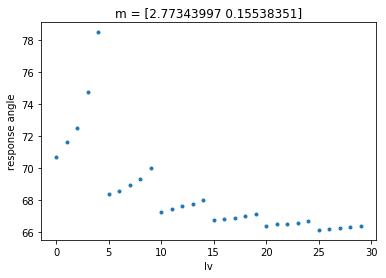

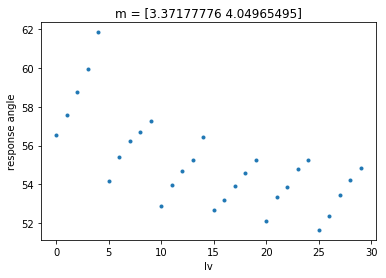

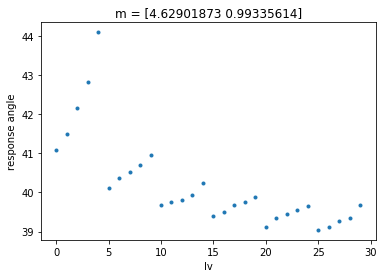

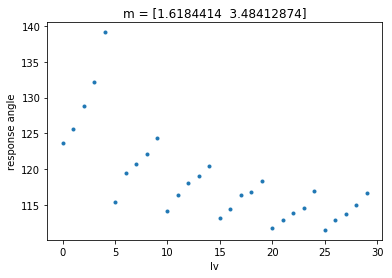

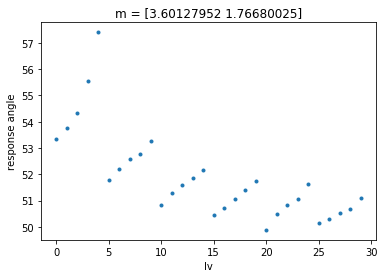

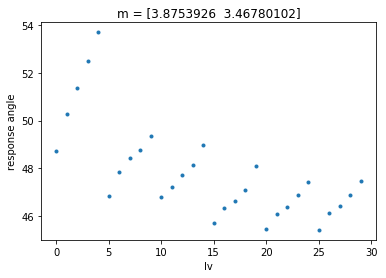

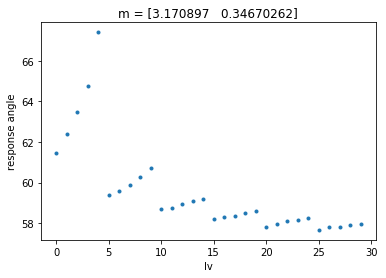

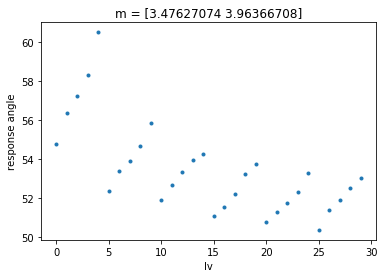

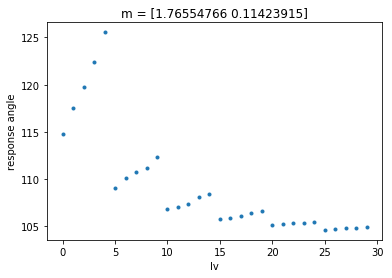

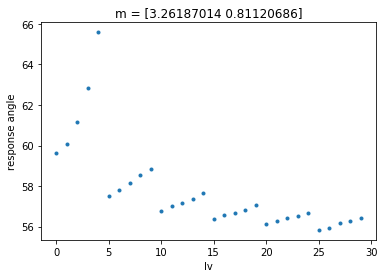

In [30]:
gparams, stats = g.gen(10)
for i in range(10):
    plt.figure()
    plt.plot(stats[i, :], '.')
    plt.ylabel(r'response angle')
    plt.xlabel(r'lv')
    plt.title('m = ' + str(gparams[i]))
    #print(stats[i, :])

In [31]:
dat_idx = 1
gen_dat = stats[dat_idx][np.newaxis, :]
print(gparams[dat_idx])
gen_dat.shape

[3.37177776 4.04965495]


(1, 30)

In [32]:
def run_fit(n_hiddens, n_train, n_rounds, epochs, data, seed):
    inf_snpe = SNPE(generator=g, n_components=1, n_hiddens=n_hiddens, obs=data, verbose=True, seed=seed)
    logs, tds, posteriors = inf_snpe.run(n_train=n_train, n_rounds=n_rounds, epochs=epochs)
    posterior = posteriors[-1]
    return logs, posterior

def run_fit_with(g, n_hiddens, n_train, n_rounds, epochs, data, seed):
    inf_snpe = SNPE(generator=g, n_components=1, n_hiddens=n_hiddens, obs=data, verbose=True, seed=seed)
    logs, tds, posteriors = inf_snpe.run(n_train=n_train, n_rounds=n_rounds, epochs=epochs)
    posterior = posteriors[-1]
    return logs, posterior

In [33]:
def plot_losses(logs):
    for log_idx, log in enumerate(logs):
        plt.figure()
        plt.plot(log['loss'])
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title('Round ' + str(log_idx+1))
        
def plot_pdfs(posterior):
    lims = np.array([[0, 8],[0, 10], [0, 5]])
    viz.plot_pdf(posterior.xs[0], lims=lims, labels_params=['m', 'noise_std', 'vt_std'],
                 figsize=(12,12), ticks=True);
    
def plot_fitting_results(logs, posterior):
    plot_losses(logs)
    plot_pdfs(posterior)

In [48]:
logs_list = [[], []]
posterior_list = [[], []]
test_dict = {'posterior': []}
for dat_idx in range(2):
    gen_dat = stats[dat_idx][np.newaxis, :]
    print('current true parameter: ' + str(gparams[dat_idx]))
    pn_train = [100]
    logs, posterior = run_fit(n_hiddens=[500], n_train=pn_train, n_rounds=len(pn_train), epochs=100, data=gen_dat, seed=100)
    logs_list[dat_idx].append(logs)
    posterior_list[dat_idx].append(posterior)
    test_dict['posterior'].append(posterior)
    print('estimated parameter: ' + str(posterior.mean))
    #plot_fitting_results(logs, posterior)

current true parameter: [2.77343997 0.15538351]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


estimated parameter: [ 1.68611662 -0.08394325]
current true parameter: [3.37177776 4.04965495]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


estimated parameter: [0.35283878 0.13680199]


In [49]:
mydf = pd.DataFrame(test_dict)

In [72]:
for wk in g.workers:
    print(wk.is_alive())
    wk.terminate()

False
False
False
False
False
False


In [51]:
mydf.to_hdf('pandas_test2', key='experimental_data', mode='w')

/home/warkentin/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:1299: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->['posterior']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [52]:
loaded_mydf = pd.read_hdf('pandas_test2', key='experimental_data')

In [55]:
pst = loaded_mydf['posterior'][0]

In [56]:
pst.mean

array([ 1.68611662, -0.08394325])

In [61]:
param_names = ['a', 'ab']
gen_params = [1, 34]
gen_params_dict = dict([(param_name, param_val) for param_name, param_val in zip(param_names, gen_params)])
gen_params_df = pd.DataFrame(gen_params_dict, index=[0])
gen_params_df.to_hdf('scalar_test.hdf5', key='values', mode='a')

In [58]:
gen_params_dict

{'a': 1, 'ab': 34}

In [41]:
import pickle
with open('test_posteriors_file.pickle', 'wb') as handle:
    pickle.dump(posterior_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [42]:
with open('test_posteriors_file.pickle', 'rb') as handle:
    b = pickle.load(handle)
b

[[<delfi.distribution.mixture.GaussianMixture.MoG at 0x7f9c42cfe940>],

In [47]:
pst = b[0][0]
pst

(<matplotlib.figure.Figure at 0x7f355036ac50>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f355036af60>,
       dtype=object))

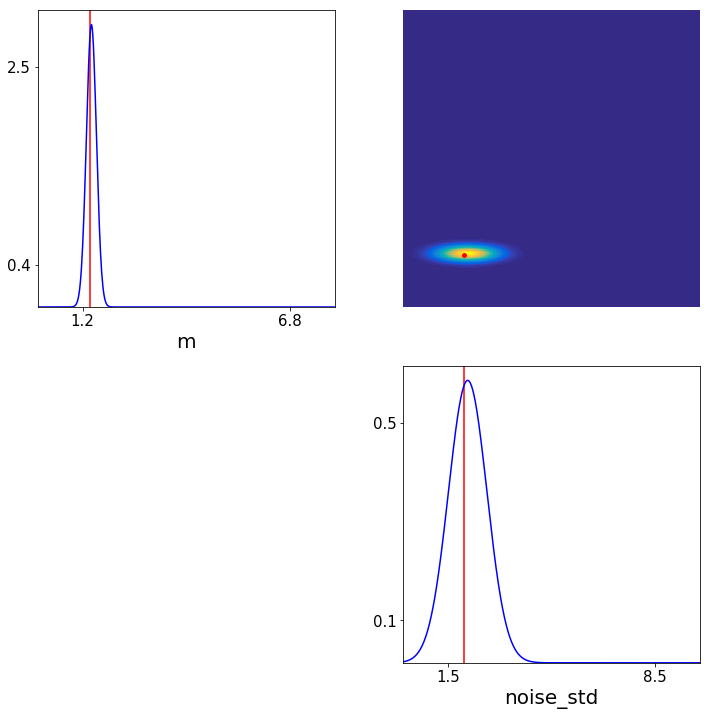

In [118]:
lims = np.array([[0, 8],[0, 10], [0, 5]])
viz.plot_pdf(posterior.xs[0], lims=lims, labels_params=['m', 'noise_std', 'vt_std'], gt=gparams[1],
             figsize=(12,12), ticks=True)

In [120]:
expm_data = np.concatenate((clean_dict['resp_angle'], clean_dict['lv'])).reshape((1, 492))
expm_data.shape

(1, 492)

## Fitting experimental data

In [129]:
expm_sum_stats = np.concatenate(qnt_list)[np.newaxis,:]
expm_sum_stats.shape

(1, 30)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


estimated parameter: [ 2.8372904  26.67321659]


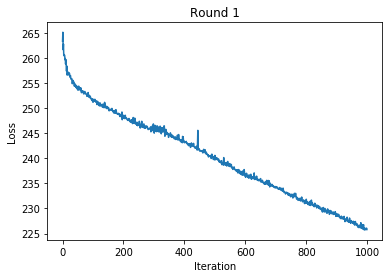

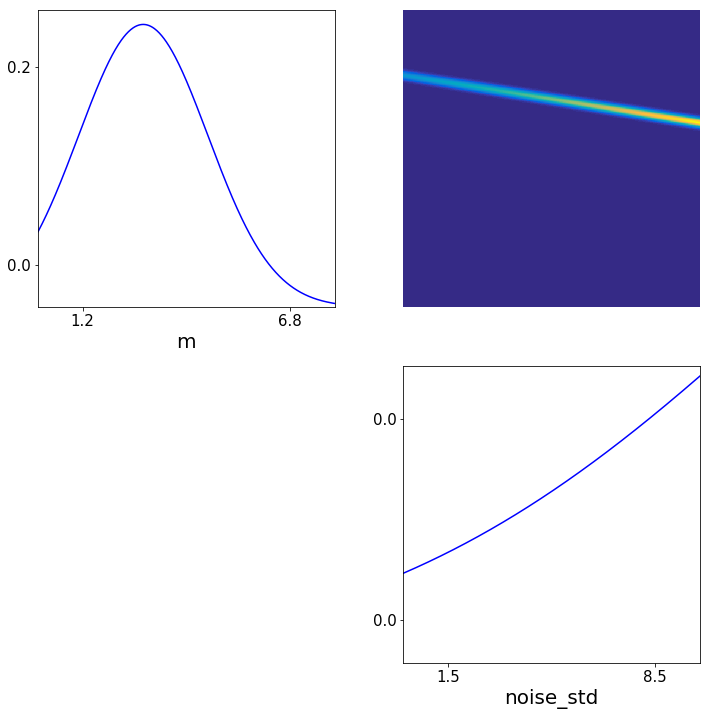

In [130]:
pn_train = [1000]
logs, posterior = run_fit(n_hiddens=[500], n_train=pn_train, n_rounds=len(pn_train), epochs=100, data=expm_sum_stats, seed=100)
print('estimated parameter: ' + str(posterior.mean))
plot_fitting_results(logs, posterior)

In [214]:
n_hidden_values = [[10], [100], [500], [100]*3, [100]*5]
n_train_values = [[500], [1000], [500, 200], [1000, 200], [500, 200, 200], [200, 200, 200]]
n_rounds_values = [len(vals) for vals in n_train_values]
epochs_values = [100, 500]

In [206]:
logs_list = [[[] for i in range(len(n_train_values))] for j in range(len(n_hidden_values))]
print(logs_list)

[[[], []], [[], []], [[], []], [[], []], [[], []]]


In [216]:
logs_list = [[[] for i in range(len(n_train_values))] for j in range(len(n_hidden_values))]
posterior_list = [[[] for i in range(len(n_train_values))] for j in range(len(n_hidden_values))]
for n_hidden_idx, n_hidden_val in enumerate(n_hidden_values):
    for n_train_idx, (n_train_val, n_rounds_val) in enumerate(zip(n_train_values, n_rounds_values)):
        for epochs_val in epochs_values:
            logs, posterior = run_fit(n_hidden_val, n_train_val, n_rounds_val, epochs_val)
            logs_list[n_hidden_idx][n_train_idx].append(logs)
            posterior_list[n_hidden_idx][n_train_idx].append(posterior)

In [217]:
len(logs_list)

5

In [256]:
n_hidden

[[10], [100], [500], [100, 100, 100], [100, 100, 100, 100, 100]]

In [298]:
data_cols = ['n_hidden', 'n_train', 'n_rounds', 'n_epochs', 'mean_m', 'mean_noise', 'mean_vt_std',
             'std_m', 'std_noise', 'std_vt_std', 'final_loss']
data_dict = dict([(col_name, []) for col_name in data_cols])
for n_hidden_idx, n_hidden_val in enumerate(n_hidden_values):
    for n_train_idx, n_train_val in enumerate(n_train_values):
        for epochs_idx, epochs_val in enumerate(epochs_values):
            cposterior = posterior_list[n_hidden_idx][n_train_idx][epochs_idx]
            clogs = logs_list[n_hidden_idx][n_train_idx][epochs_idx]
            cmeans = cposterior.mean
            cstds = cposterior.std
            closs = int(10*np.log(clogs[-1]['loss'][-1]))
            result_values = [str(n_hidden_val), str(n_train_val), len(n_train_val), epochs_val, cmeans[0], cmeans[1],
                             cmeans[2], cstds[0], cstds[1], cstds[2], closs]
            for col, value in zip(data_cols, result_values):
                data_dict[col].append(value)

df = pd.DataFrame(data_dict)

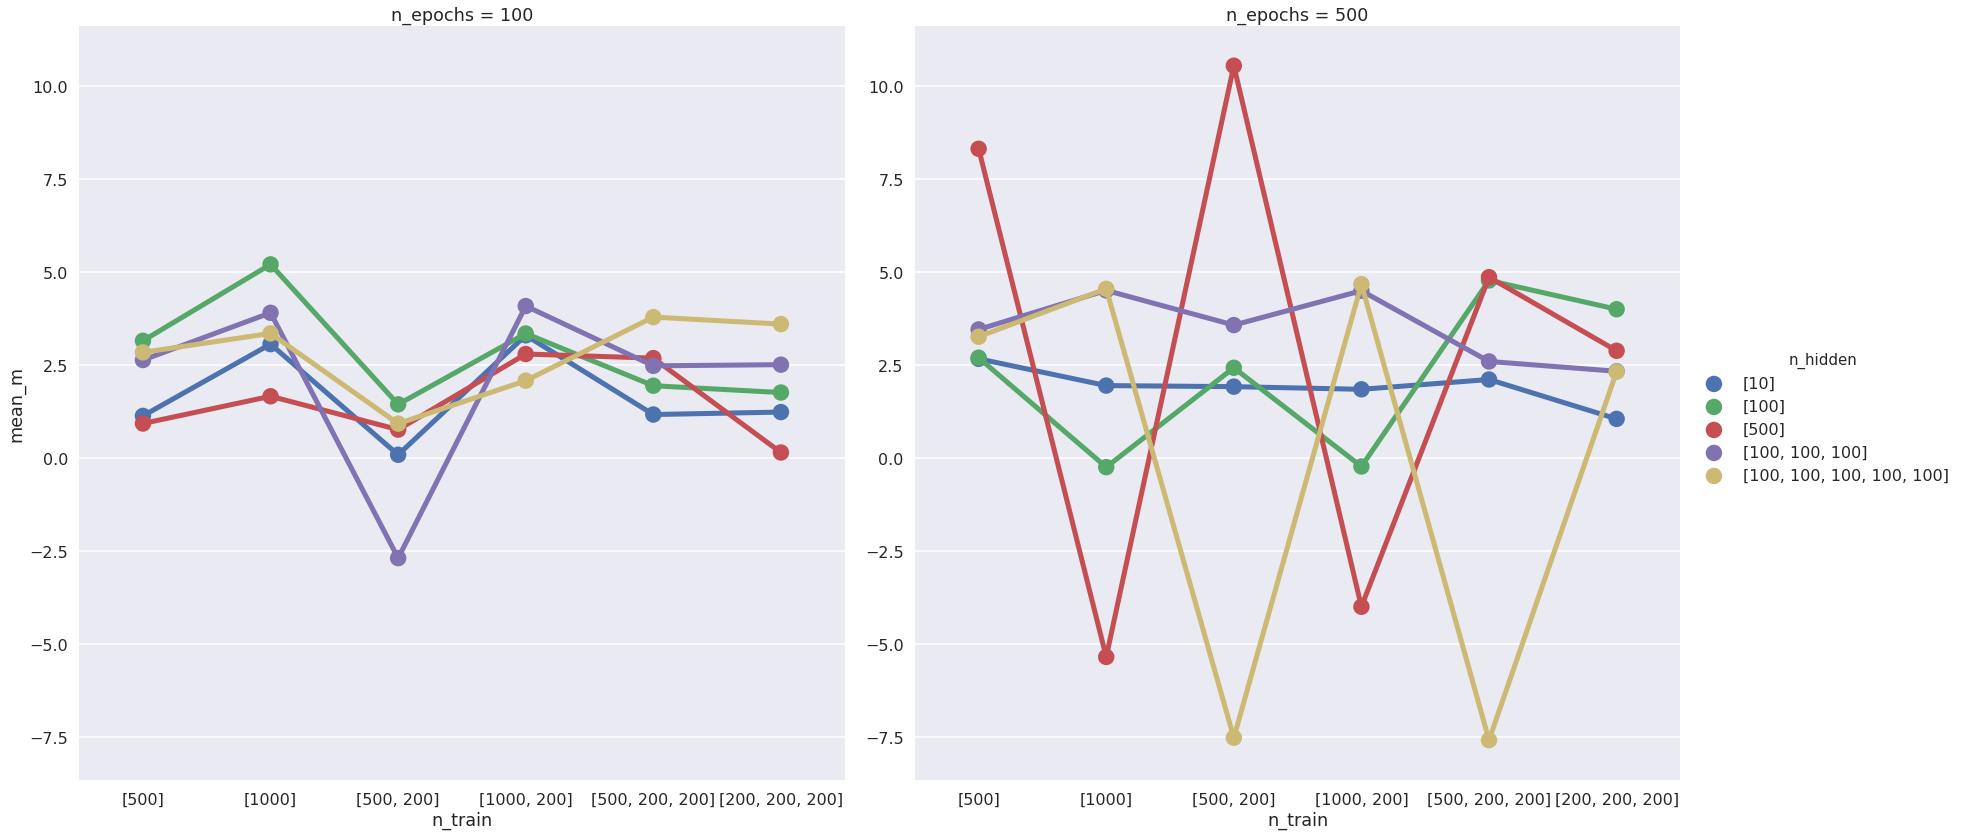

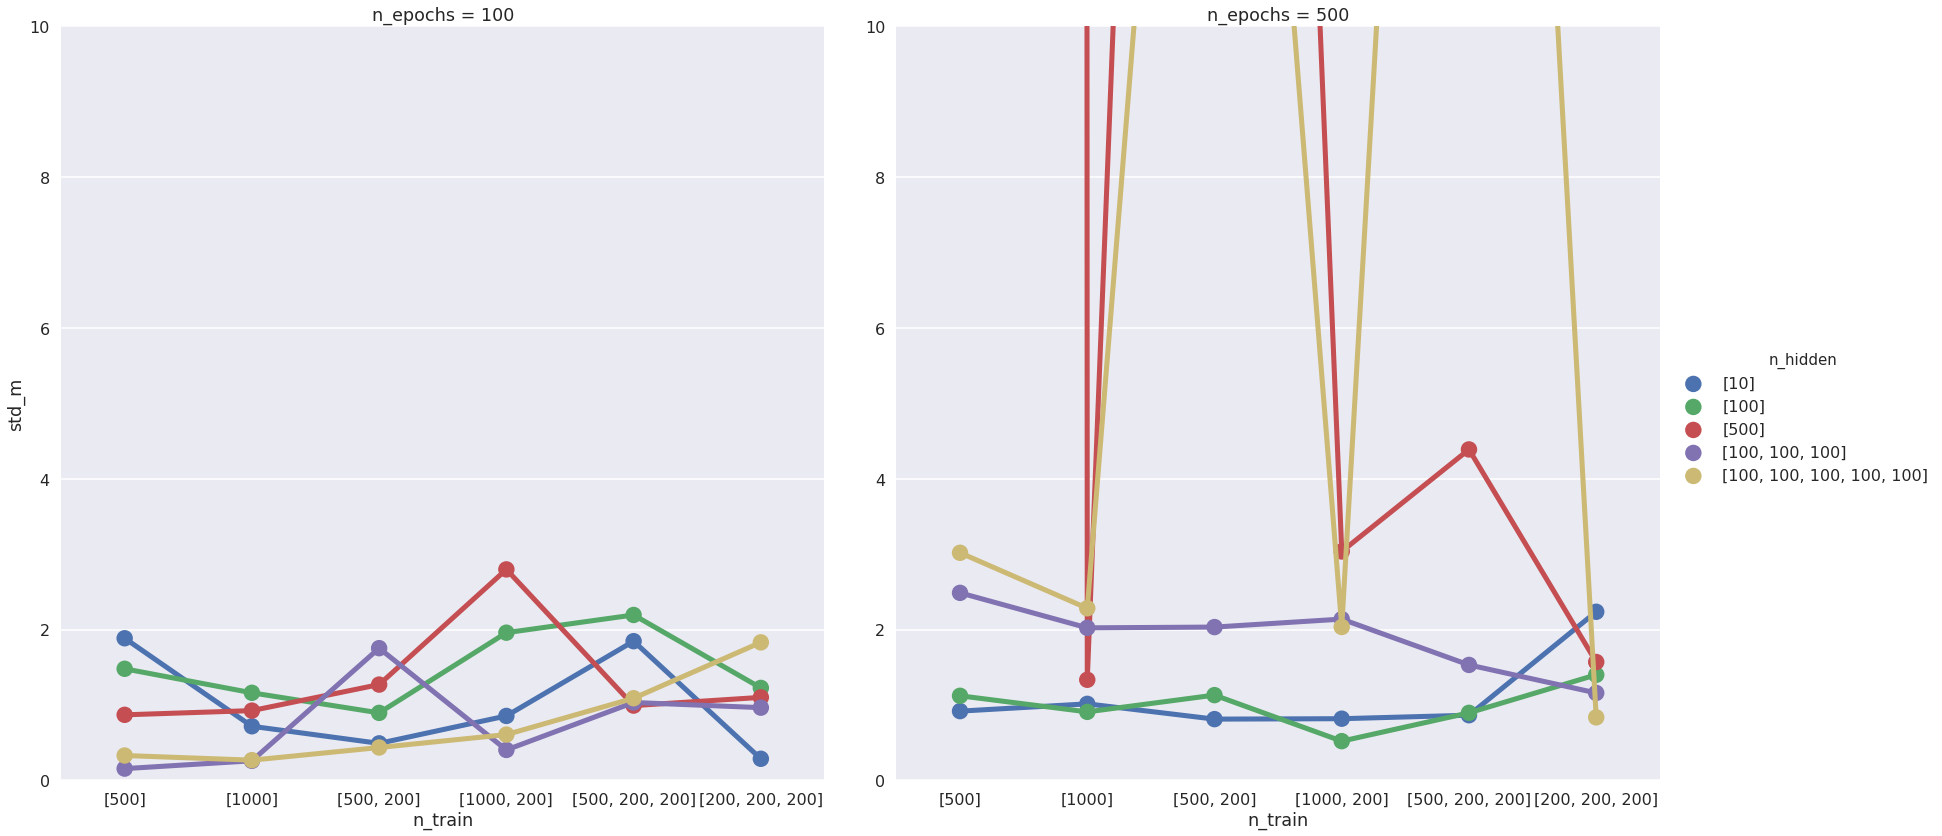

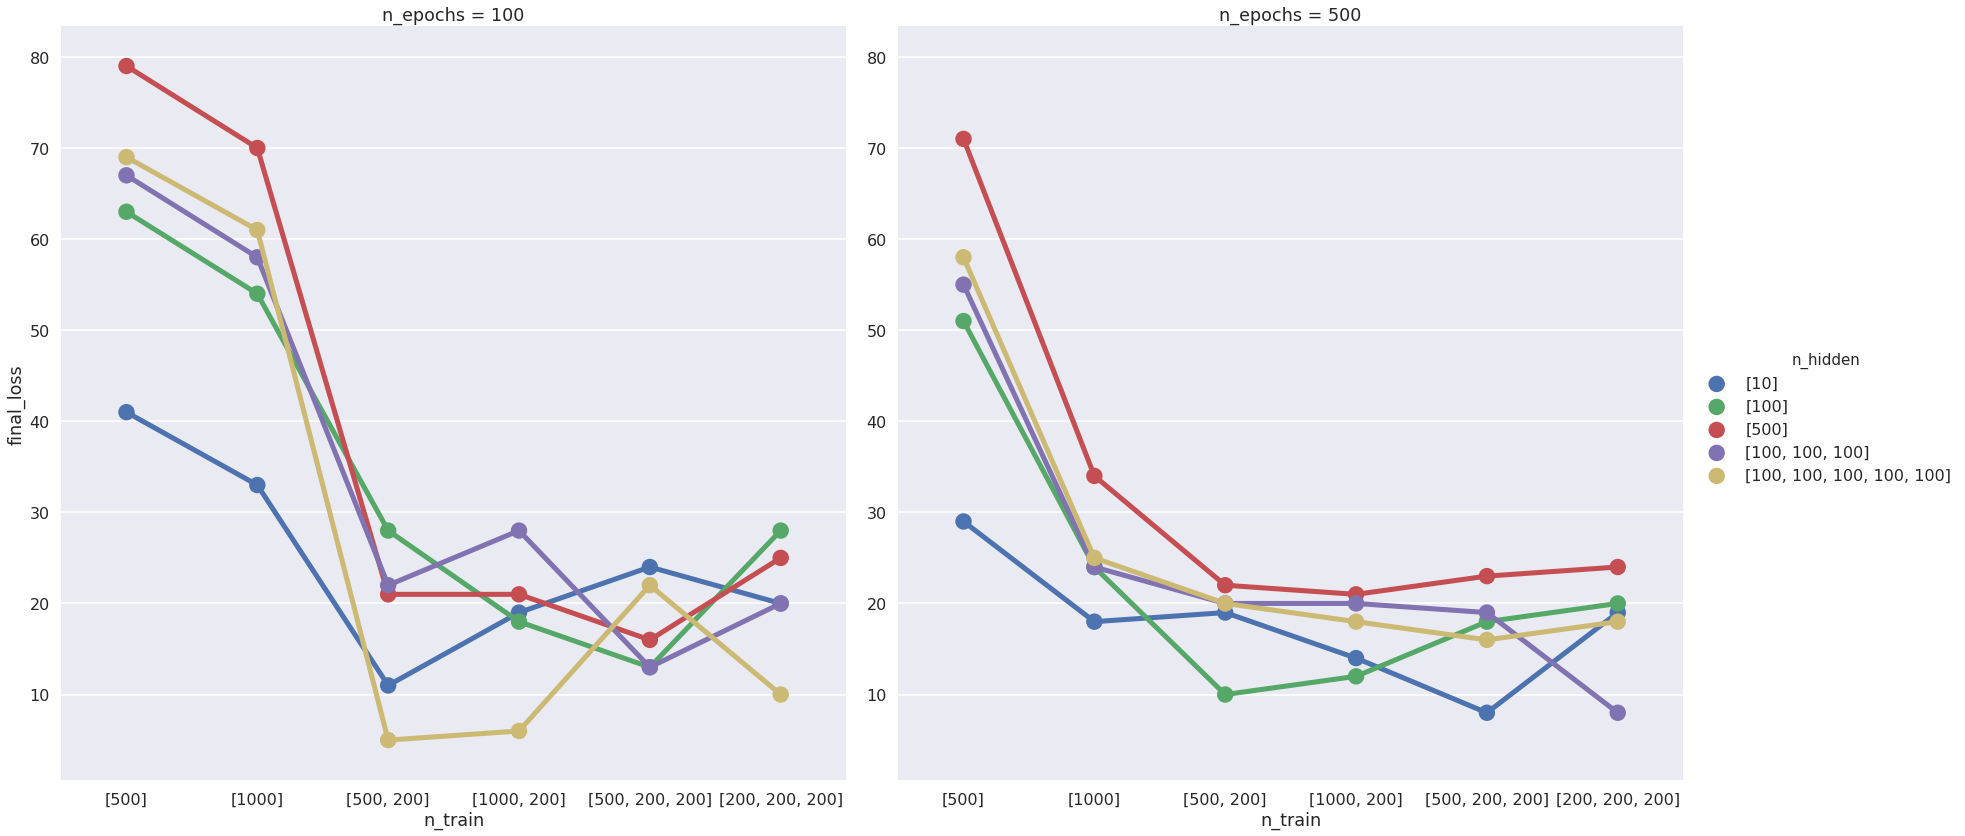

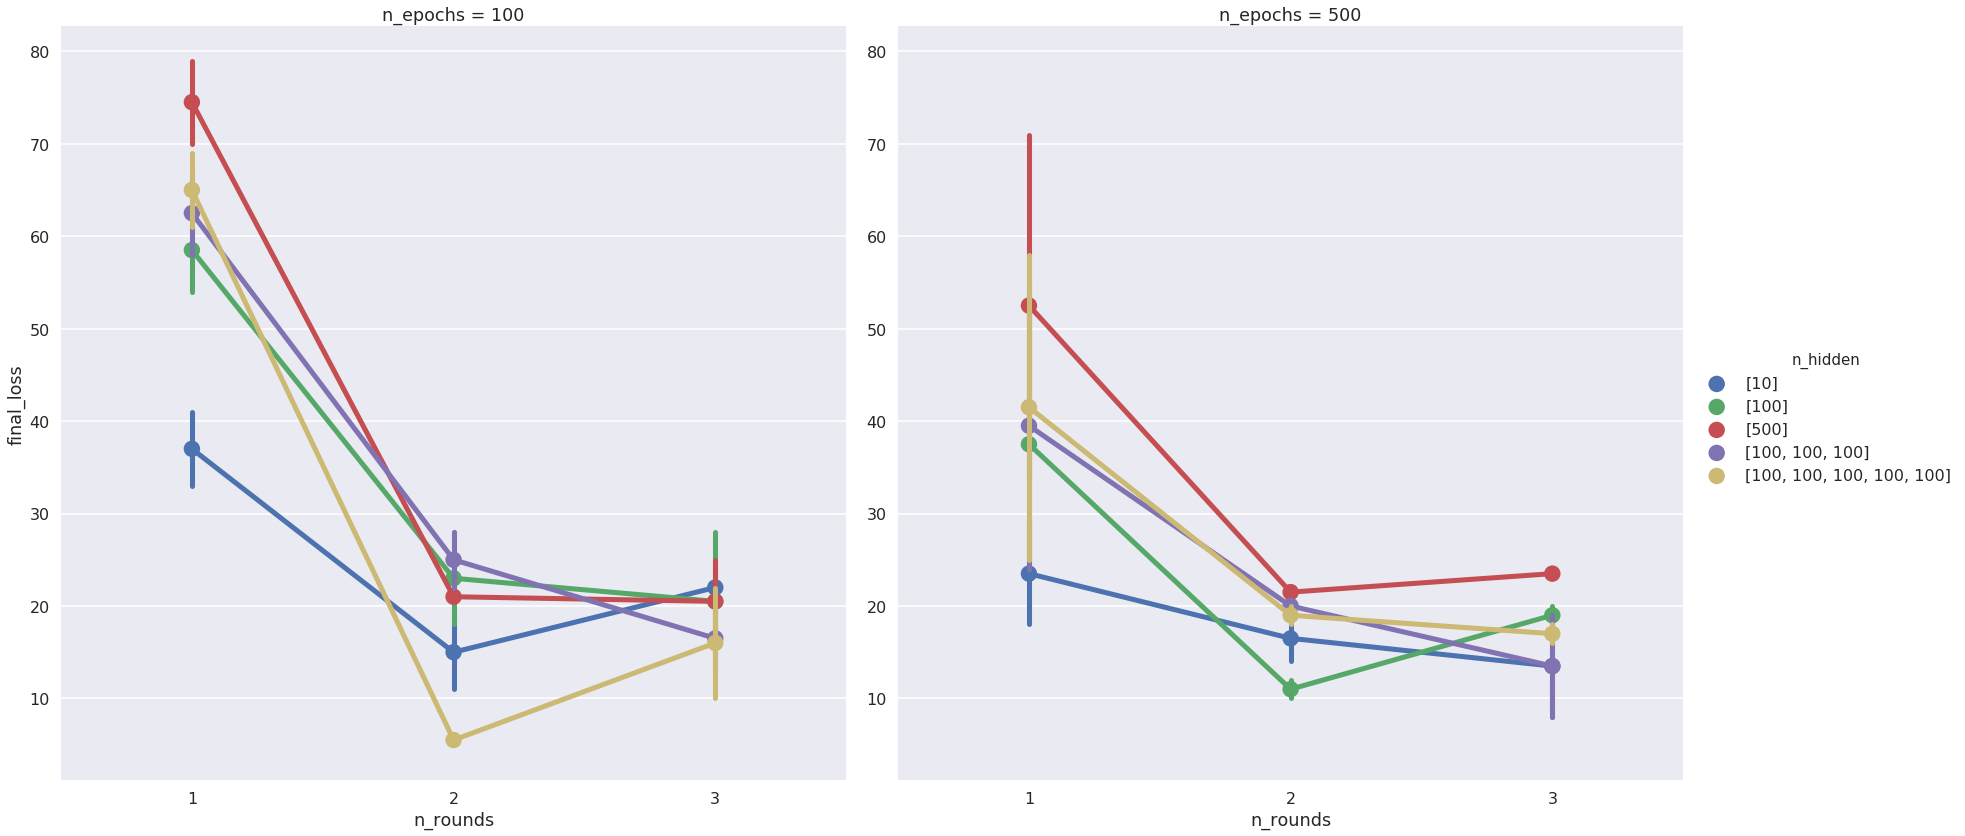

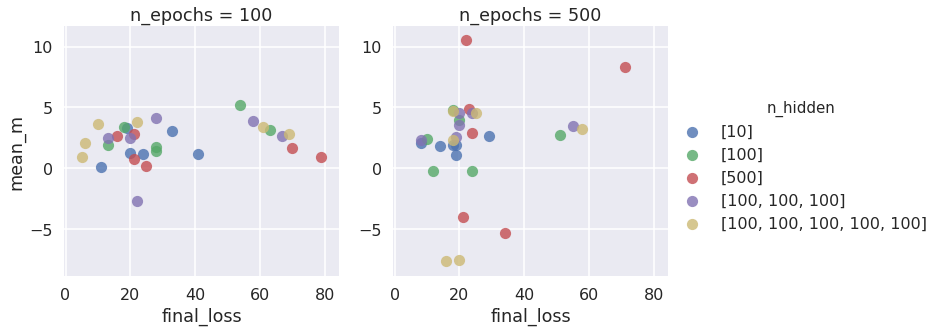

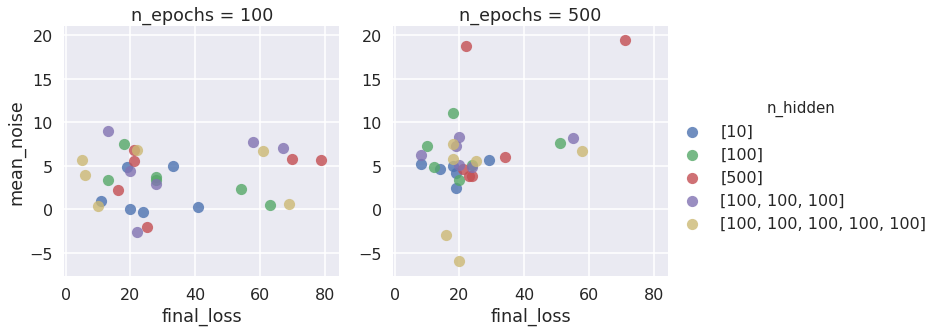

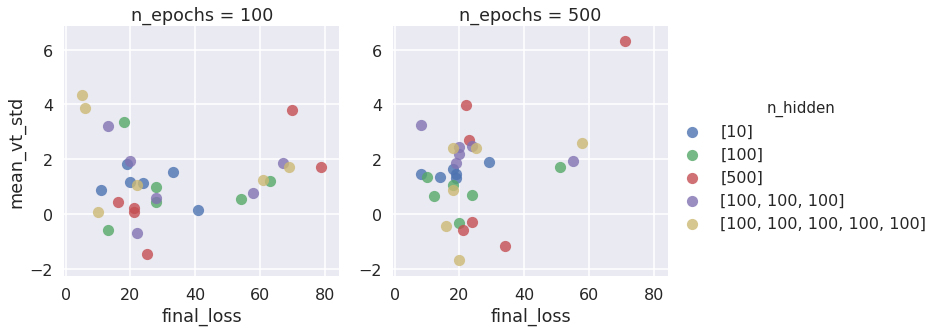

In [300]:
sns.set('poster')
sns.factorplot(x='n_train', y='mean_m', hue='n_hidden', col='n_epochs', kind='point', data=df, size=12)
sns.factorplot(x='n_train', y='std_m', hue='n_hidden', col='n_epochs', kind='point', data=df, size=12)
plt.ylim([0,10])
grid = sns.factorplot(x='n_train', y='final_loss', hue='n_hidden', col='n_epochs', kind='point', data=df, size=12)
grid = sns.factorplot(x='n_rounds', y='final_loss', hue='n_hidden', col='n_epochs', kind='point', data=df, size=12)
grid = sns.factorplot(x='n_epochs', y='final_loss', hue='n_hidden', col='n_train', kind='point', data=df, size=12)
#grid.set(yscale='log')
grid = sns.lmplot(x='final_loss', y='mean_m', hue='n_hidden', col='n_epochs', fit_reg=False, data=df)
grid = sns.lmplot(x='final_loss', y='mean_noise', hue='n_hidden', col='n_epochs', fit_reg=False, data=df)
grid = sns.lmplot(x='final_loss', y='mean_vt_std', hue='n_hidden', col='n_epochs', fit_reg=False, data=df)
#grid.set(yscale='log')

/home/warkentin/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


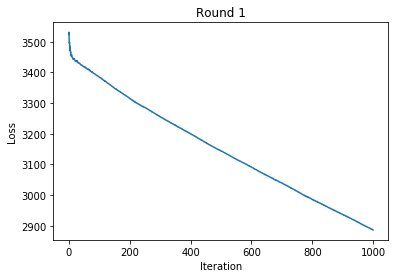

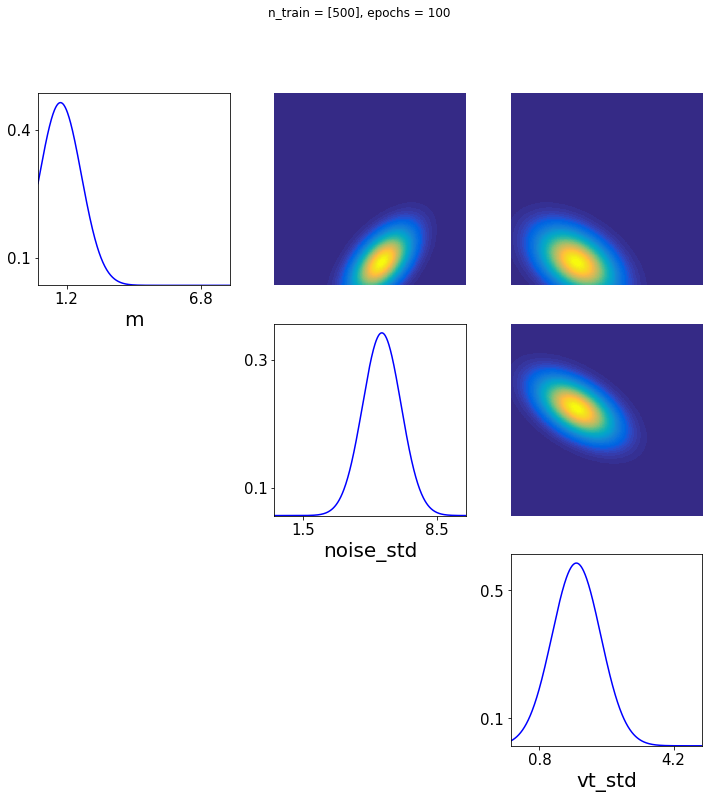

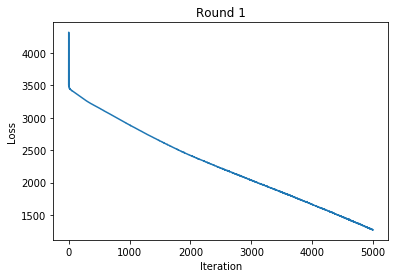

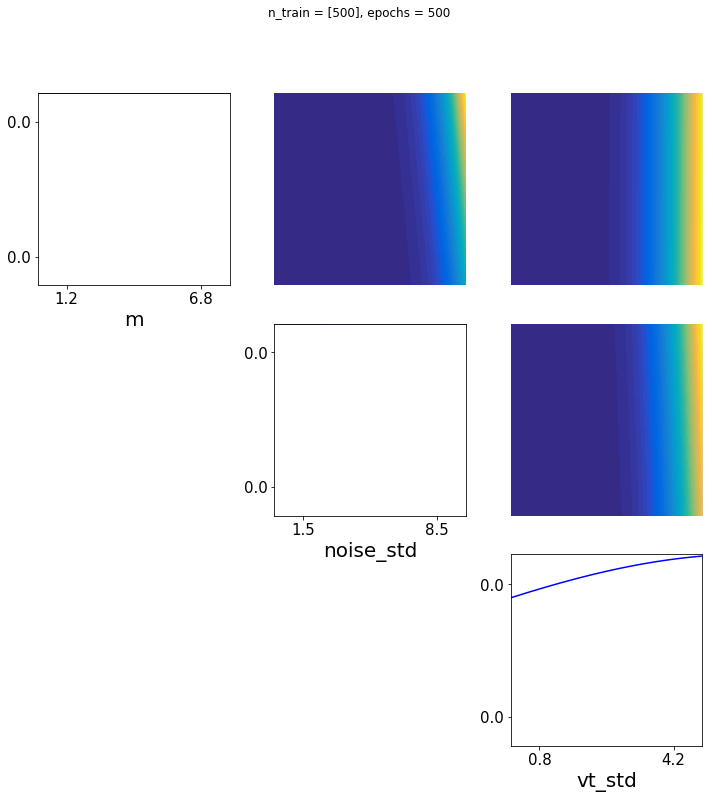

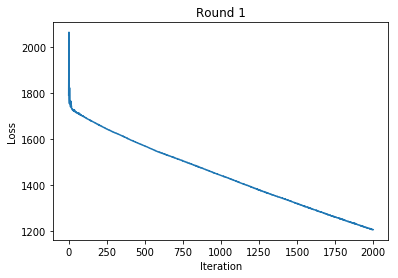

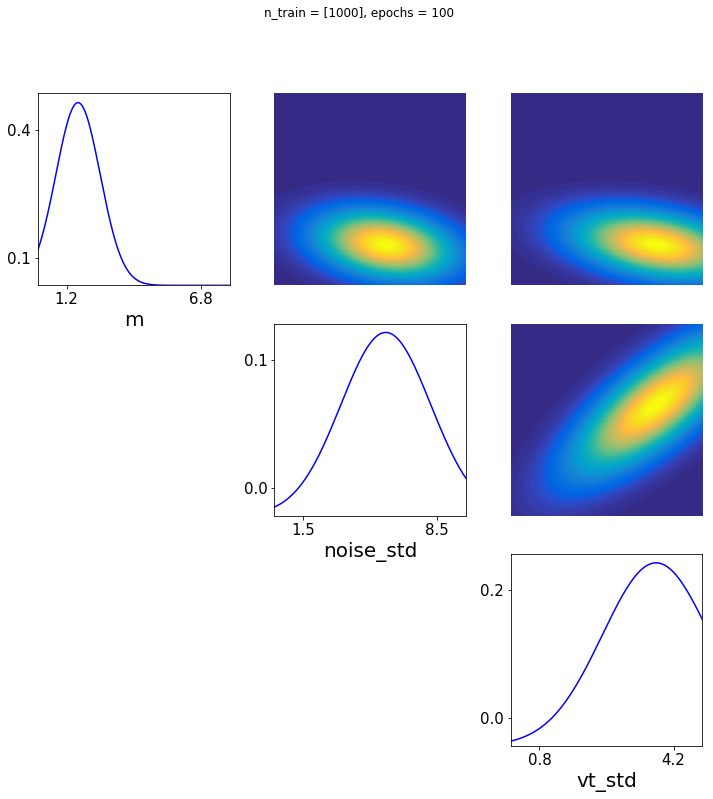

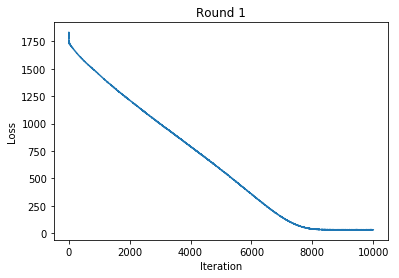

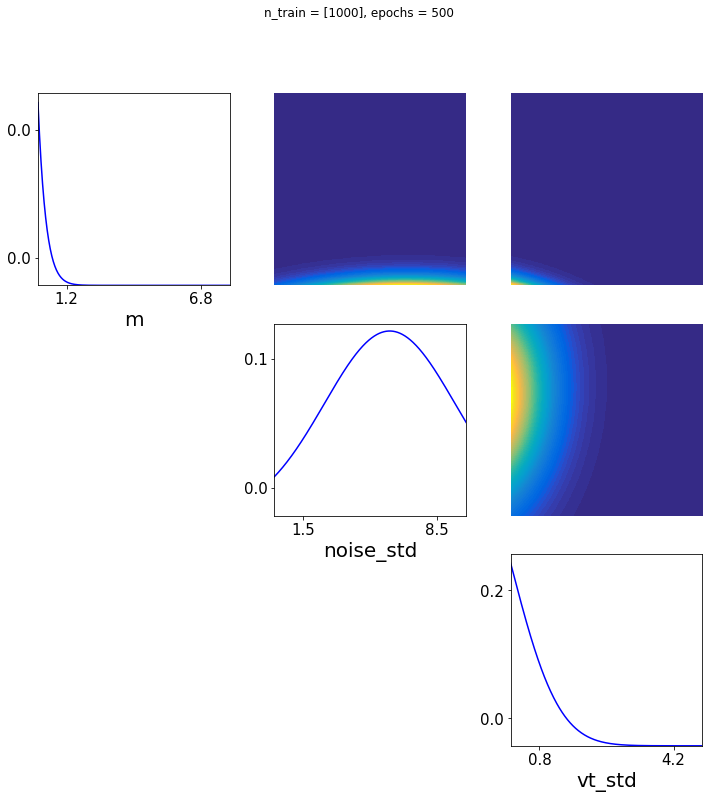

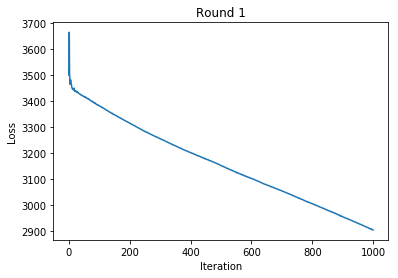

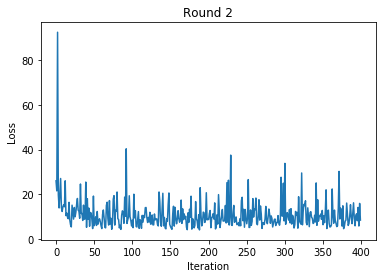

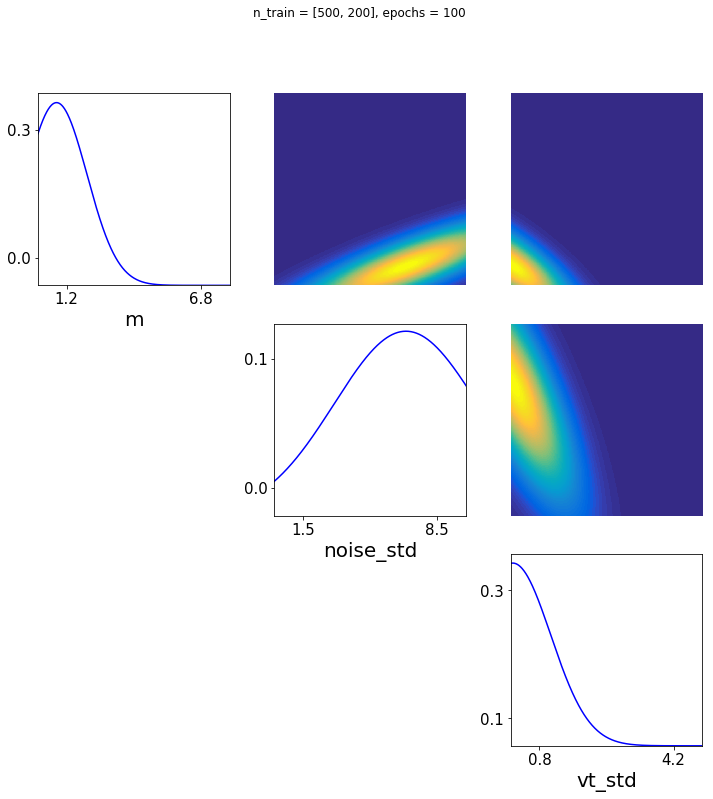

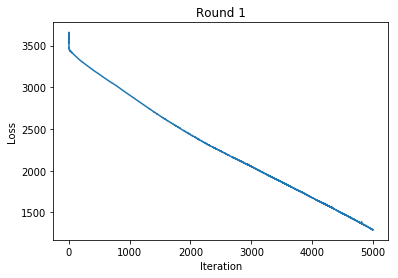

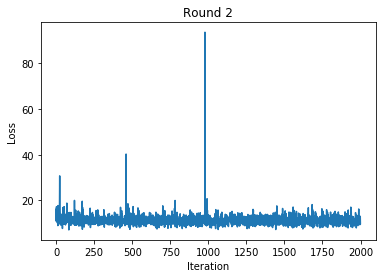

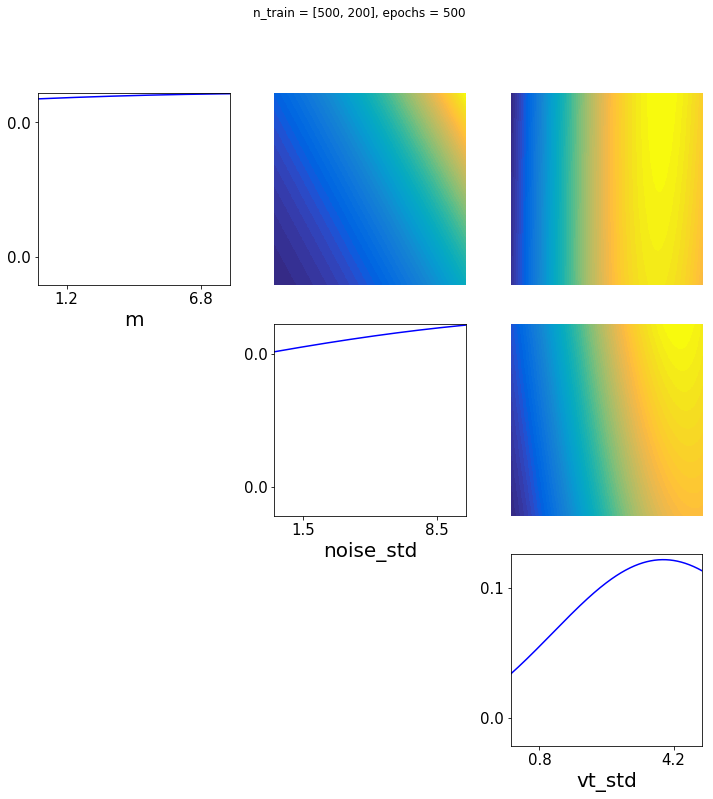

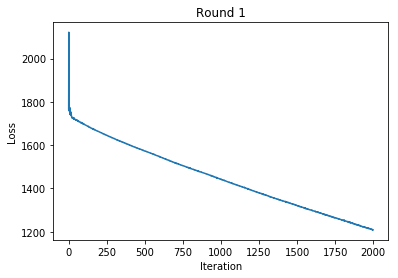

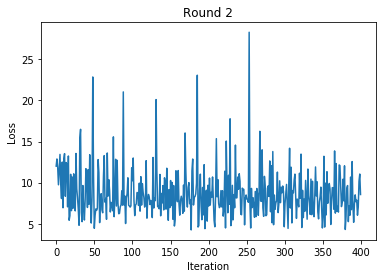

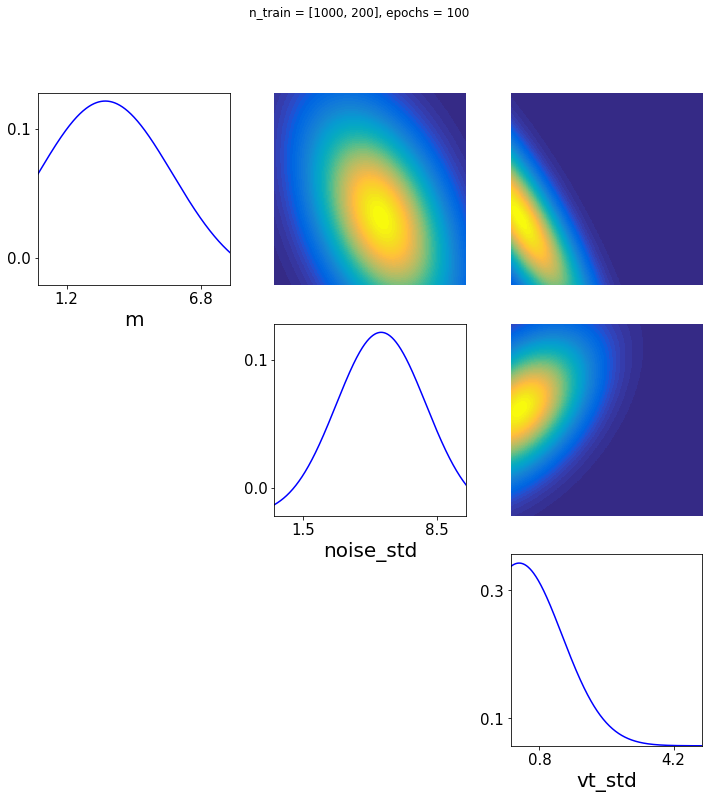

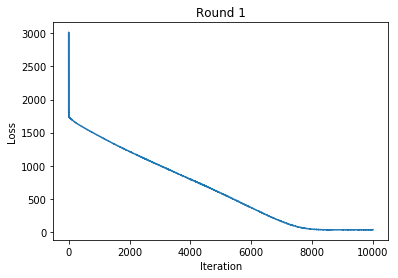

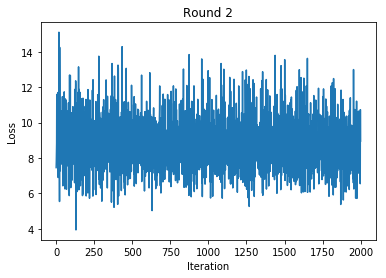

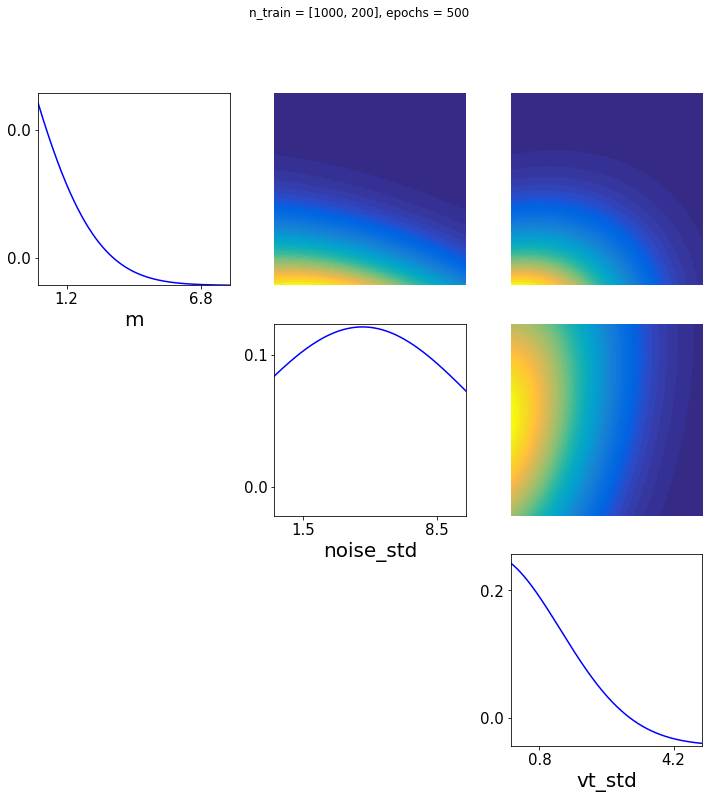

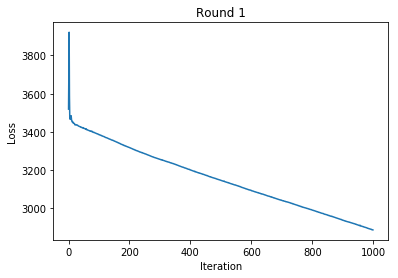

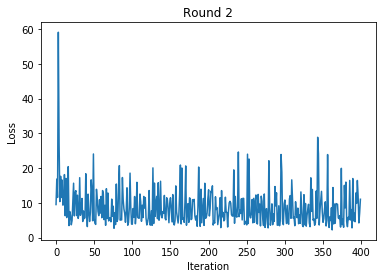

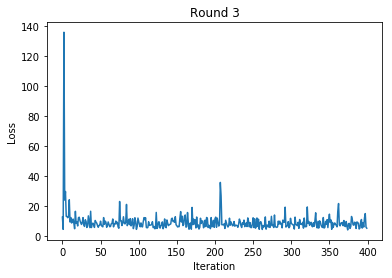

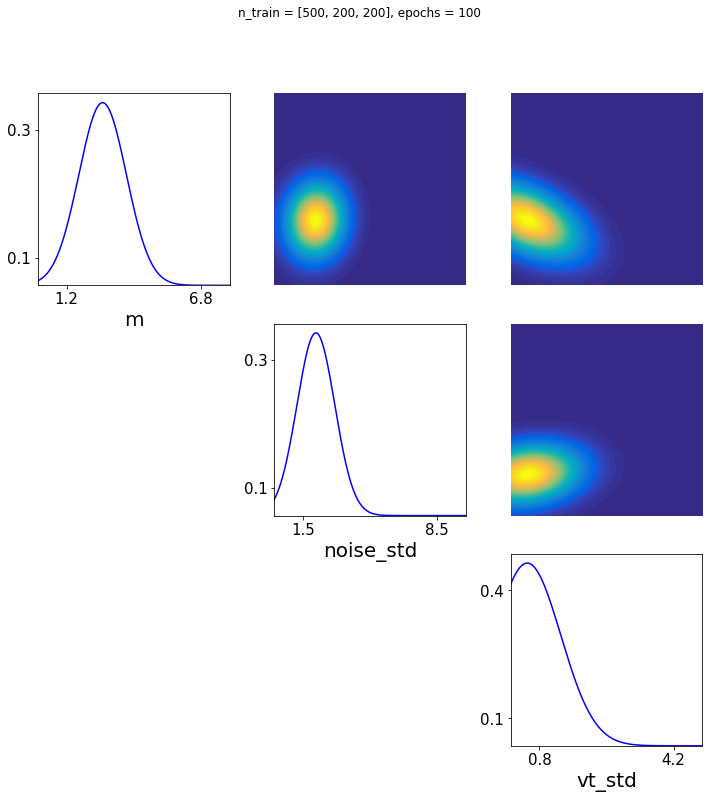

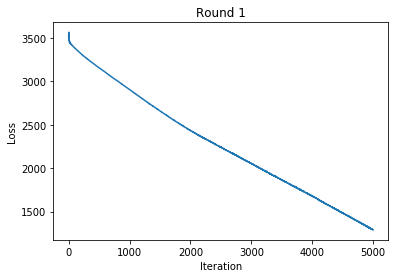

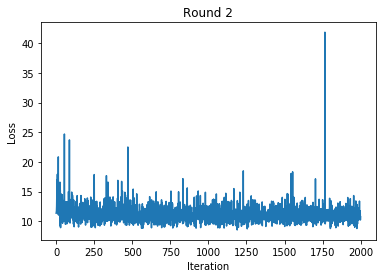

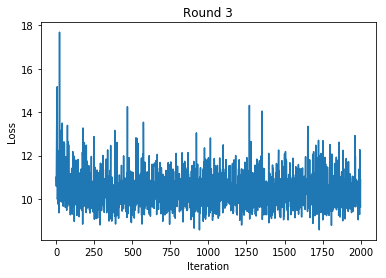

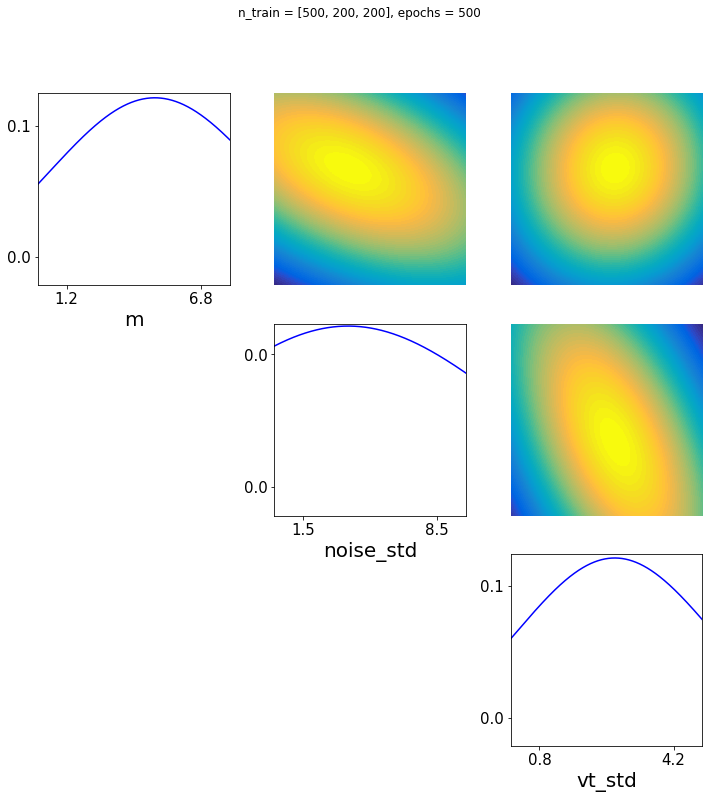

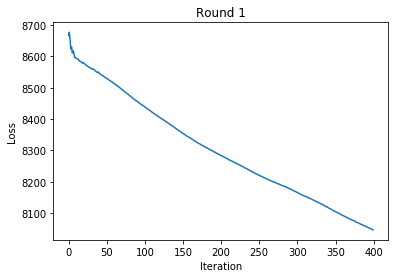

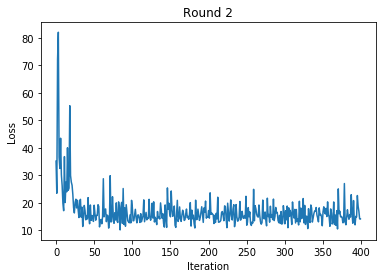

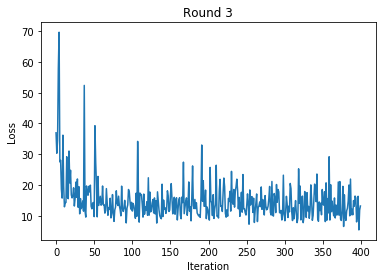

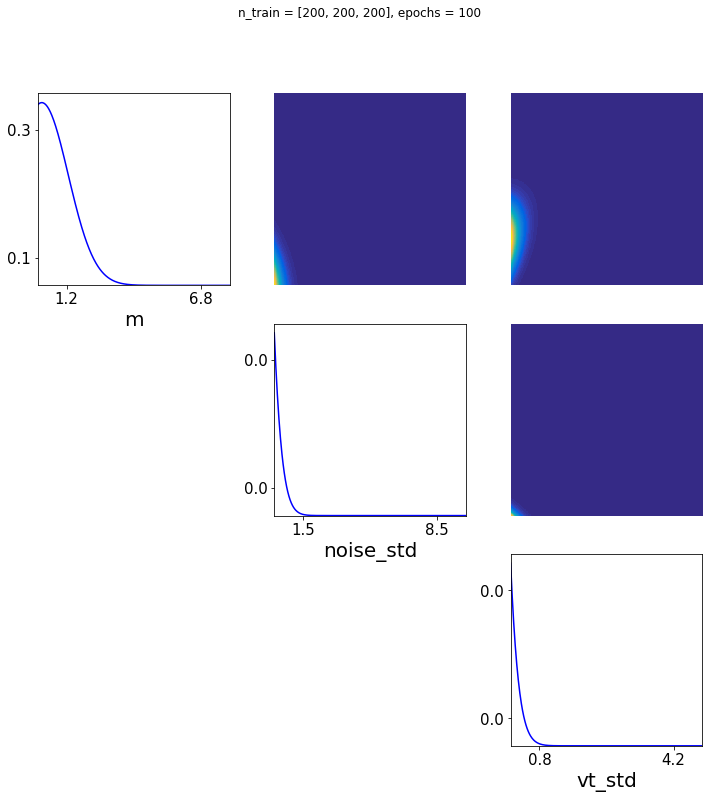

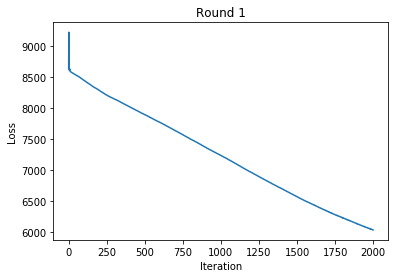

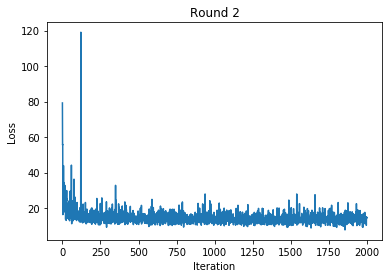

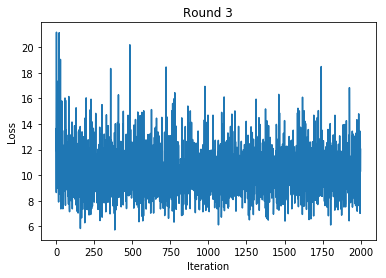

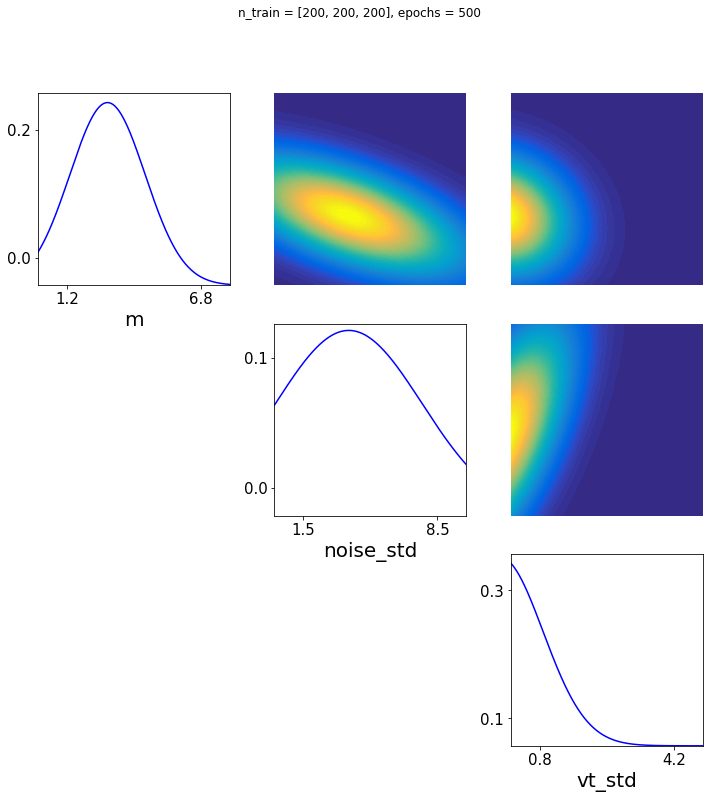

In [243]:
for n_train_idx, n_train_val in enumerate(n_train_values):
    for epochs_idx, epochs_val in enumerate(epochs_values):
        plot_fitting_results(logs_list[2][n_train_idx][epochs_idx], posterior_list[2][n_train_idx][epochs_idx])
        plt.suptitle('n_train = ' + str(n_train_val) + ', epochs = ' + str(epochs_val))

In [188]:
inf_snpe = SNPE(generator=g, n_components=1, n_hiddens=[50, 50, 50], obs=expm_data, verbose=False)
logs, tds, posteriors = inf_snpe.run(n_train=[500, 200, 200], n_rounds=3, epochs=1000)
posterior = posteriors[-1]

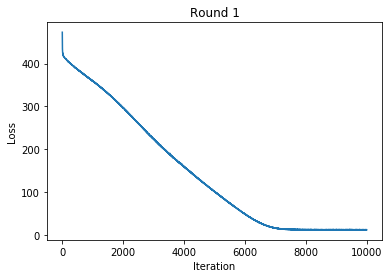

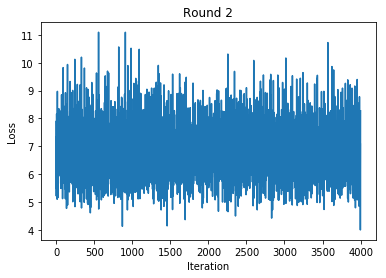

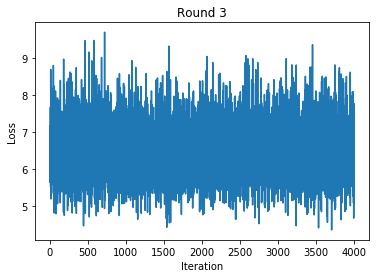

In [189]:
for log_idx, log in enumerate(logs):
    plt.figure()
    plt.plot(log['loss'])
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Round ' + str(log_idx+1))

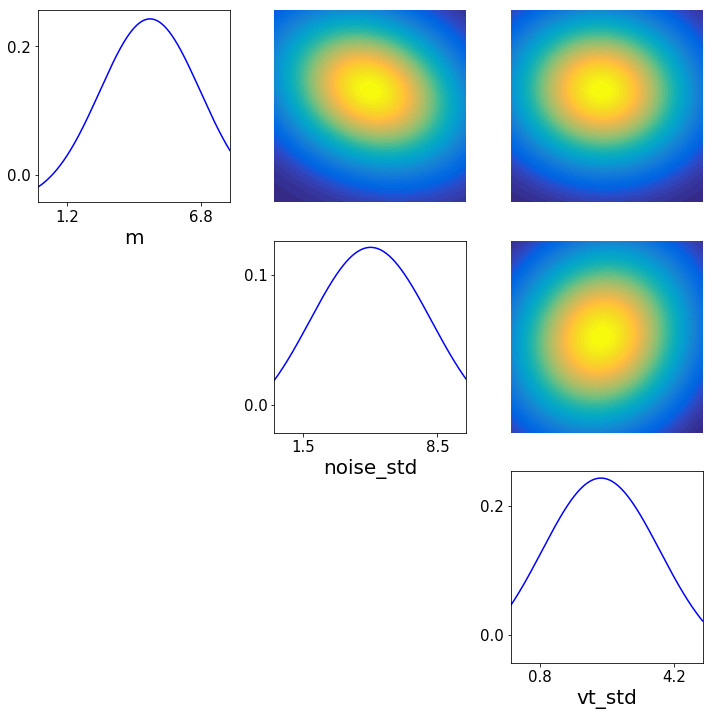

In [190]:
lims = np.array([[0, 8],[0, 10], [0, 5]])
viz.plot_pdf(posterior.xs[0], lims=lims, labels_params=['m', 'noise_std', 'vt_std'],
             figsize=(12,12), ticks=True);

In [265]:
posterior.std

array([ 1.58511074,  6.43638483,  5.21072001, 13.02542898,  2.43390069])

In [118]:
mog1 = posterior.xs[0]
mog1.C

array([[ 2.12833027, -0.41441998, -0.21905204],
       [ 0.        ,  3.30991522, -0.59642641],
       [ 0.        ,  0.        ,  1.5482229 ]])

## Feedforward inhibition model

In [224]:
def run_fit_with(g, n_hiddens, n_train, n_rounds, epochs, data, seed):
    inf_snpe = SNPE(generator=g, n_components=1, n_hiddens=n_hiddens, obs=data, verbose=True, seed=seed)
    logs, tds, posteriors = inf_snpe.run(n_train=n_train, n_rounds=n_rounds, epochs=epochs)
    posterior = posteriors[-1]
    return logs, posterior

In [225]:
class FFI(BaseSimulator):
    def __init__(self, dim=1, seed=None, fixed_params=None):
        """Feedforward inhibition model simulator
        Integrates input until a given threshold is reached at which we
        define the response time.
        Parameters
        ----------
        dim : int
            Number of dimensions of parameters
        noise_cov : list
            Covariance of noise on observations
        seed : int or None
            If set, randomness is seeded
        """
        super().__init__(dim_param=dim, seed=seed)
        self.fixed_params = fixed_params

    @copy_ancestor_docstring
    def gen_single(self, param):
        # See BaseSimulator for docstring
        param = np.asarray(param).reshape(-1)
        assert param.ndim == 1
        assert param.shape[0] == self.dim_param

        model_params = self.fixed_params.copy()
        #model_params['rho_null'] = param[0]
        model_params['noise_std_exc'] = param[0]*1e-3
        #model_params['vt_std'] = param[2]*1e-3
        #model_params['exc_scale'] = param[3]
        model_params['rho_scale'] = param[1]*1e6
        nruns = 246
        rstims = np.zeros((1, nruns))
        lvs = np.zeros((1, nruns))
        for i in np.arange(nruns):
            rstims[0, i], rdist, reaction_time, lvs[0, i], stim_size, speed, rtime_to_coll = md.calc_response_ffi(model_params)

        data = np.concatenate((rstims, lvs), axis=1)
        return {'data': data}

In [226]:
total_time = 5
dt = 0.001

params = {'tau_m': 0.023,
          'e_l': -0.079,
          'r_m': 10*1e6,
          'v_t': -0.061,
          'init_vm_std': 0.000,
          'vt_std': 0.000,
          'rho_null': 2,
          'rho_null_std': 2.8,
          'tau_inh': 0.001,
          'rho_scale': 9.6*1e6,
          'exc_scale': 30,
          'dt': dt,
          'total_time': total_time,
          'init_period': 2,
          'noise_std_exc': 5*1e-3,
          'noise_std_inh': 5*1e-3,
          'n_timepoints': int(total_time/dt),
          'cutoff_angle': 180,
          'm': 3,
          'b': 0,
          'lv_min': 0.1,
          'lv_max': 1.2,
          'l_min': 10,
          'l_max': 25,
          'init_distance': 50}

ffim = FFI(dim=2, fixed_params=params)

# params are: rho_null, noise_std_exc, vt_std, exc_scale, rho_scale
p = dd.Uniform(lower=[0, 5.0], upper=[5, 10.0])
#s = Identity()
s = LVQuantiles()
g = MPGenerator(models=[ffim]*5, prior=p, summary=s)

Process Worker-128:
Process Worker-126:
Process Worker-125:
Process Worker-127:
Process Worker-124:
Traceback (most recent call last):
  File "/home/warkentin/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/warkentin/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/warkentin/.local/lib/python3.6/site-packages/delfi-0.4.1-py3.6.egg/delfi/generator/MPGenerator.py", line 45, in run
    result = self.model.gen(params_batch, pbar=self)
  File "/home/warkentin/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/warkentin/.local/lib/python3.6/site-packages/delfi-0.4.1-py3.6.egg/delfi/simulator/BaseSimulator.py", line 51, in gen
    rep_list.append(self.gen_single(param))
  File "/home/warkentin/.local/lib/python3.6/site-pac

In [218]:
def plot_ffi_losses(logs):
    for log_idx, log in enumerate(logs):
        plt.figure()
        plt.plot(log['loss'])
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title('Round ' + str(log_idx+1))
        
def plot_ffi_pdfs(posterior):
    lims = np.array([[0, 5],[5, 10]])
    viz.plot_pdf(posterior.xs[0], lims=lims, labels_params=['noise_std_exc', 'rho_scale'],
                 figsize=(12,12), ticks=True);
    
def plot_ffi_fitting_results(logs, posterior):
    plot_ffi_losses(logs)
    plot_ffi_pdfs(posterior)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


estimated parameter: [1.63325304 2.73190235 6.27182766]


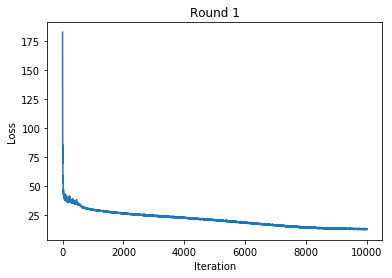

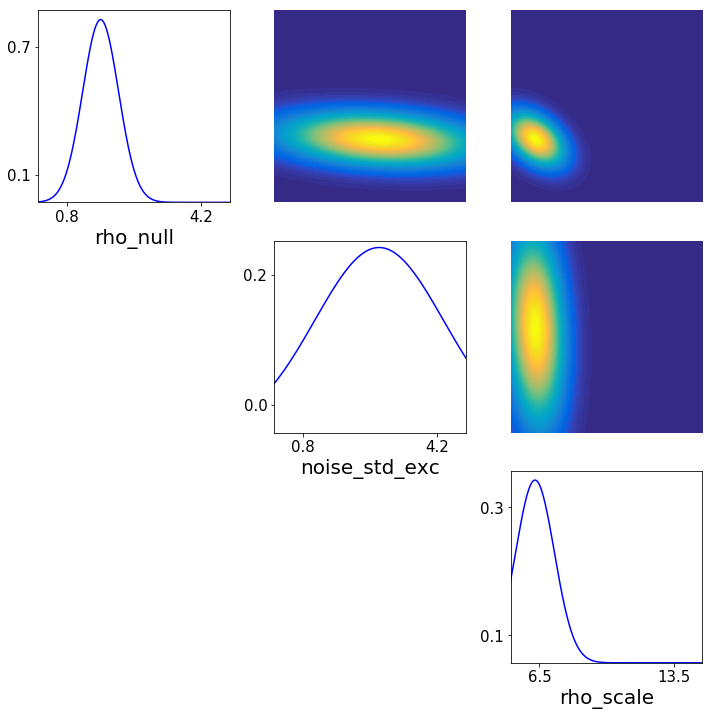

In [156]:
pn_train = [5000]
logs, posterior = run_fit_with(g, n_hiddens=[500], n_train=pn_train, n_rounds=len(pn_train), epochs=100, data=expm_sum_stats, seed=100)
print('estimated parameter: ' + str(posterior.mean))
plot_ffi_fitting_results(logs, posterior)

Total time needed: 0 seconds or 0 min or 0 hours


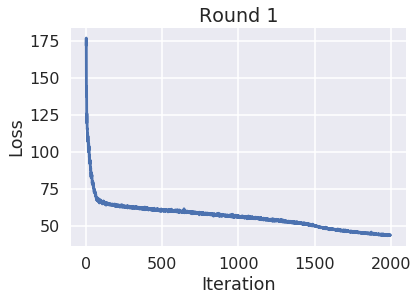

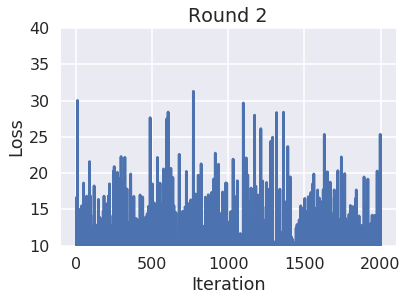

In [170]:
import time

starttime = time.time()

plot_ffi_losses(logs)
plt.ylim([10, 40])

endtime = time.time()
print('Total time needed: ' + str(int((endtime - starttime))) + ' seconds or '
      + str(int((endtime - starttime) / 60)) + ' min '
      + 'or ' + str(int((endtime - starttime) / 3600)) + ' hours')

In [176]:
import time

starttime = time.time()

n_hidden_values = [[500], [500, 500], [1000]]
n_train_values = [[500], [1000], [5000], [10000]]
n_rounds_values = [len(vals) for vals in n_train_values]
epochs_values = [100, 500]

ffi_logs_list = [[[] for i in range(len(n_train_values))] for j in range(len(n_hidden_values))]
ffi_posterior_list = [[[] for i in range(len(n_train_values))] for j in range(len(n_hidden_values))]
for n_hidden_idx, n_hidden_val in enumerate(n_hidden_values):
    for n_train_idx, (n_train_val, n_rounds_val) in enumerate(zip(n_train_values, n_rounds_values)):
        print('current train index = ' + str(n_train_idx))
        for epochs_val in epochs_values:
            logs, posterior = run_fit_with(g, n_hidden_val, n_train_val, n_rounds_val, epochs_val, expm_sum_stats, seed=100)
            ffi_logs_list[n_hidden_idx][n_train_idx].append(logs)
            ffi_posterior_list[n_hidden_idx][n_train_idx].append(posterior)
            
endtime = time.time()
print('Total time needed: ' + str(int((endtime - starttime))) + ' seconds or '
      + str(int((endtime - starttime) / 60)) + ' min '
      + 'or ' + str(int((endtime - starttime) / 3600)) + ' hours')

current train index = 0
current train index = 1
current train index = 2
current train index = 3
current train index = 0
current train index = 1
current train index = 2
current train index = 3
current train index = 0
current train index = 1
current train index = 2
current train index = 3
Total time needed: 13458 seconds or 224 min or 3 hours


In [177]:
data_cols = ['n_hidden', 'n_train', 'n_rounds', 'n_epochs', 'mean_rho_null', 'mean_exc_noise', 'mean_rho_scale',
             'std_rho_null', 'std_exc_noise', 'std_rho_scale', 'final_loss']
data_dict = dict([(col_name, []) for col_name in data_cols])
for n_hidden_idx, n_hidden_val in enumerate(n_hidden_values):
    for n_train_idx, n_train_val in enumerate(n_train_values):
        for epochs_idx, epochs_val in enumerate(epochs_values):
            cposterior = ffi_posterior_list[n_hidden_idx][n_train_idx][epochs_idx]
            clogs = ffi_logs_list[n_hidden_idx][n_train_idx][epochs_idx]
            cmeans = cposterior.mean
            cstds = cposterior.std
            closs = int(10*np.log(clogs[-1]['loss'][-1]))
            result_values = [str(n_hidden_val), str(n_train_val), len(n_train_val), epochs_val, cmeans[0], cmeans[1],
                             cmeans[2], cstds[0], cstds[1], cstds[2], closs]
            for col, value in zip(data_cols, result_values):
                data_dict[col].append(value)

ffi_df = pd.DataFrame(data_dict)

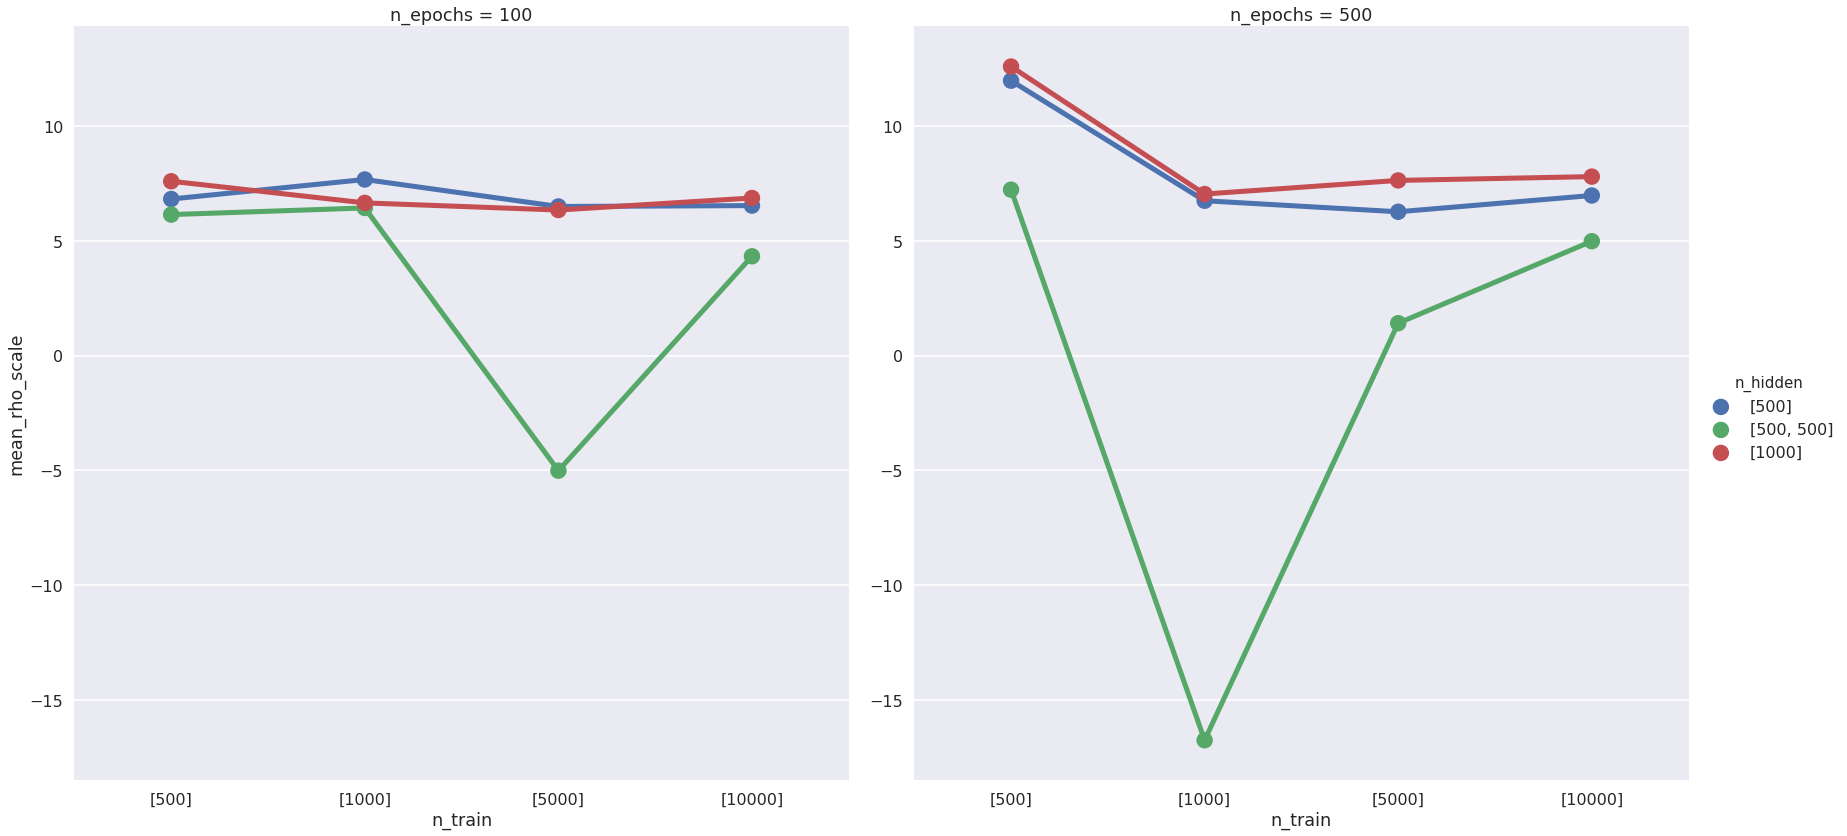

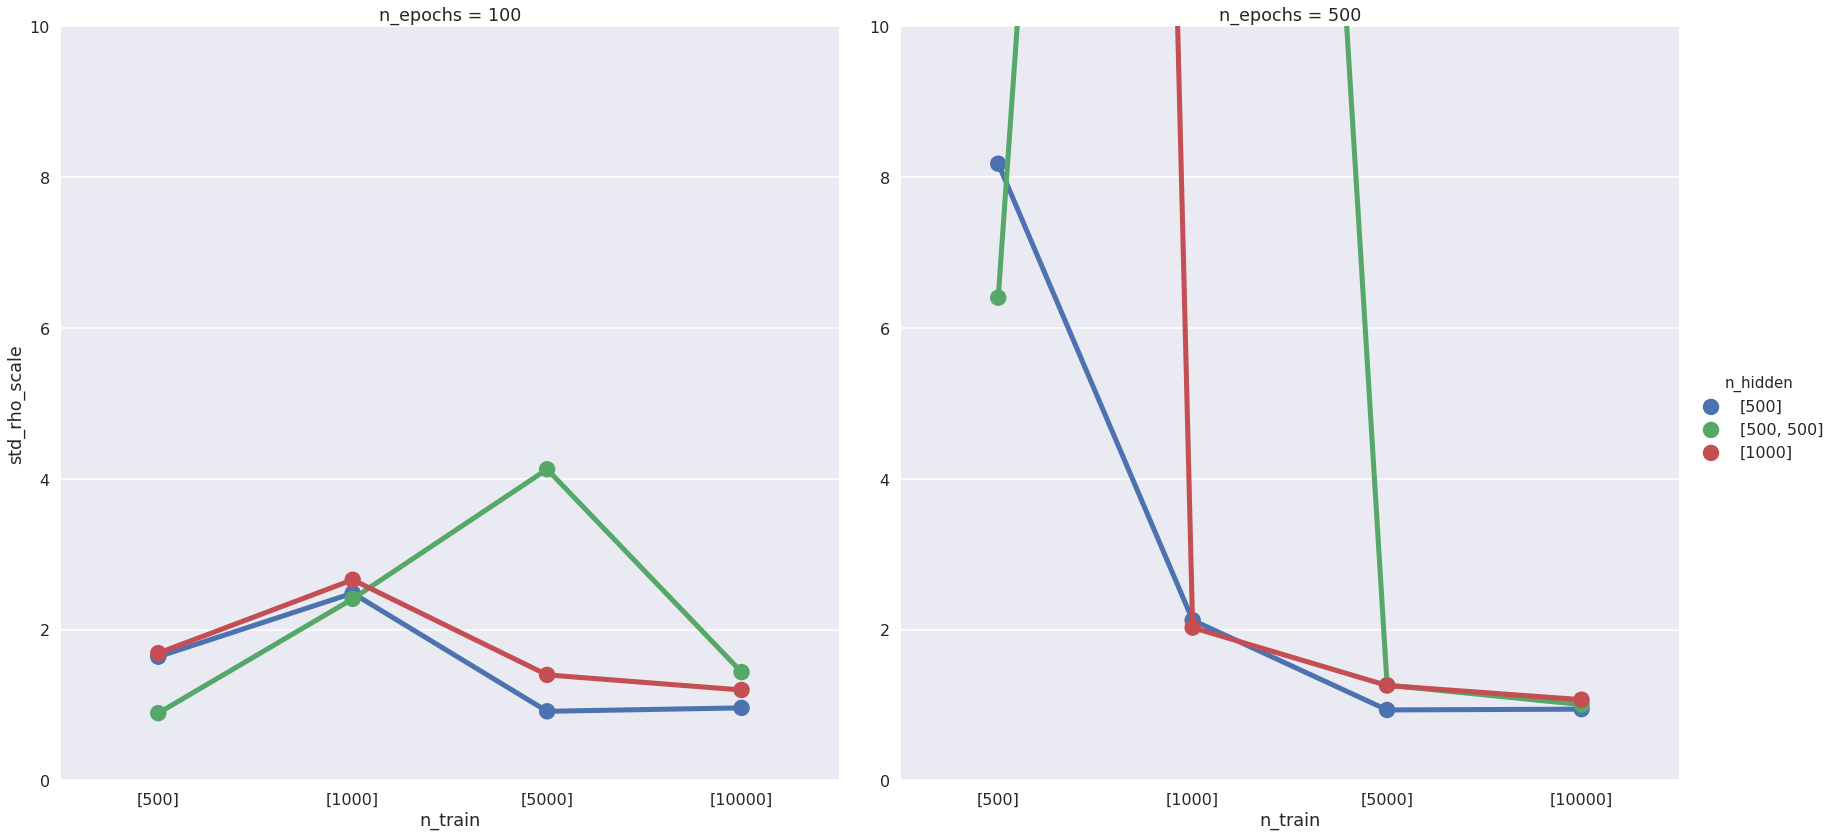

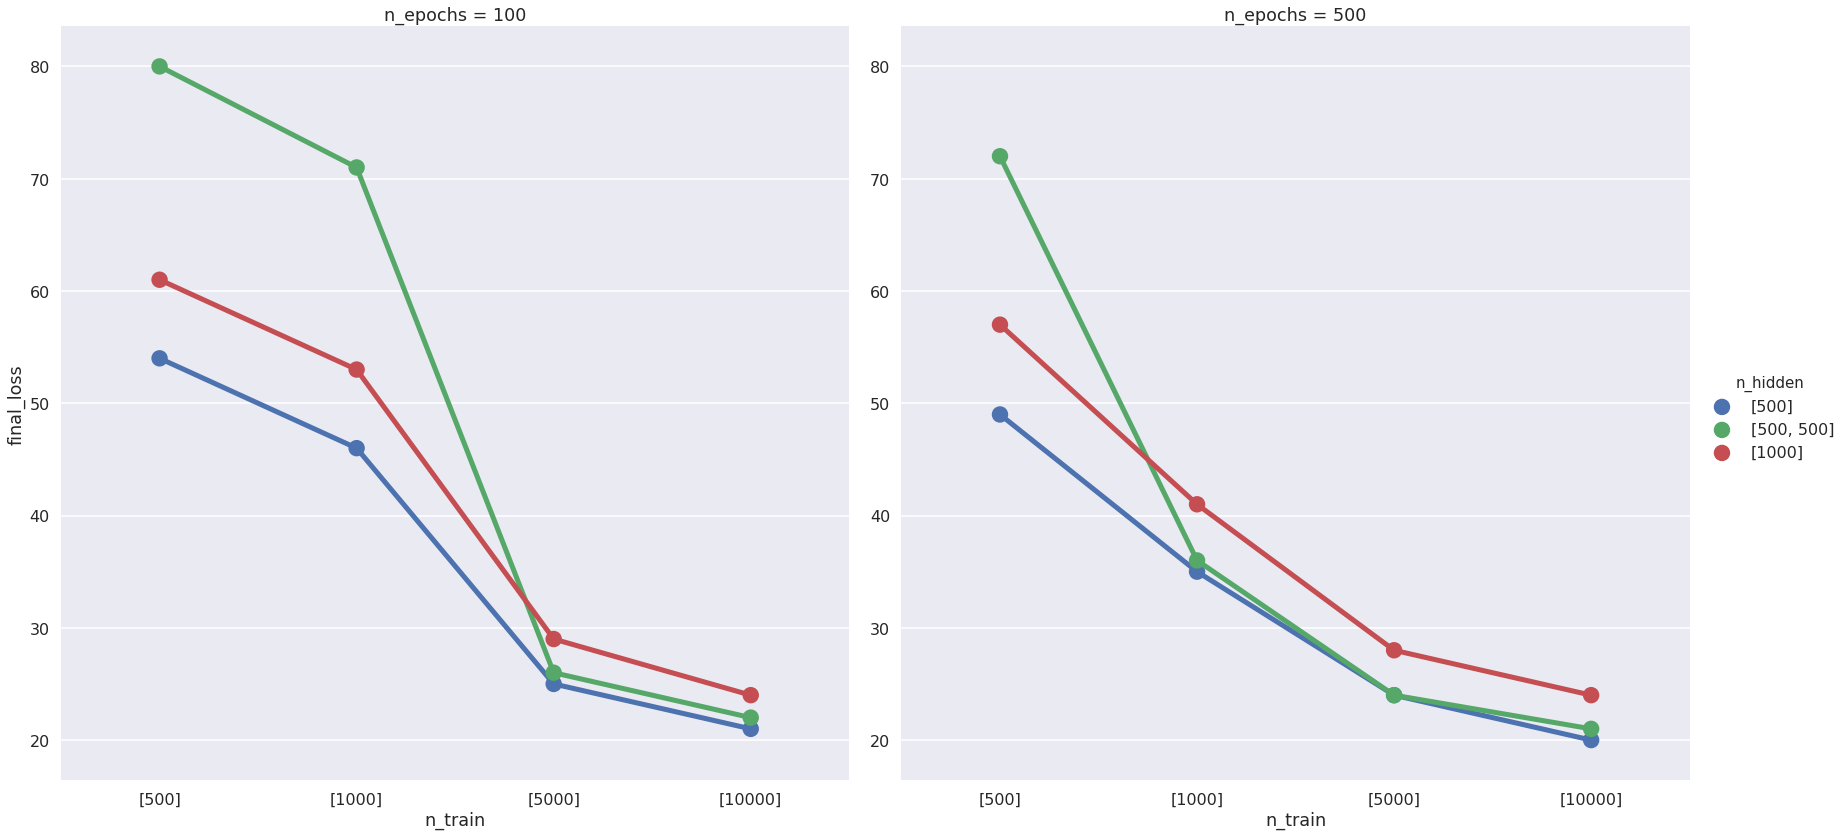

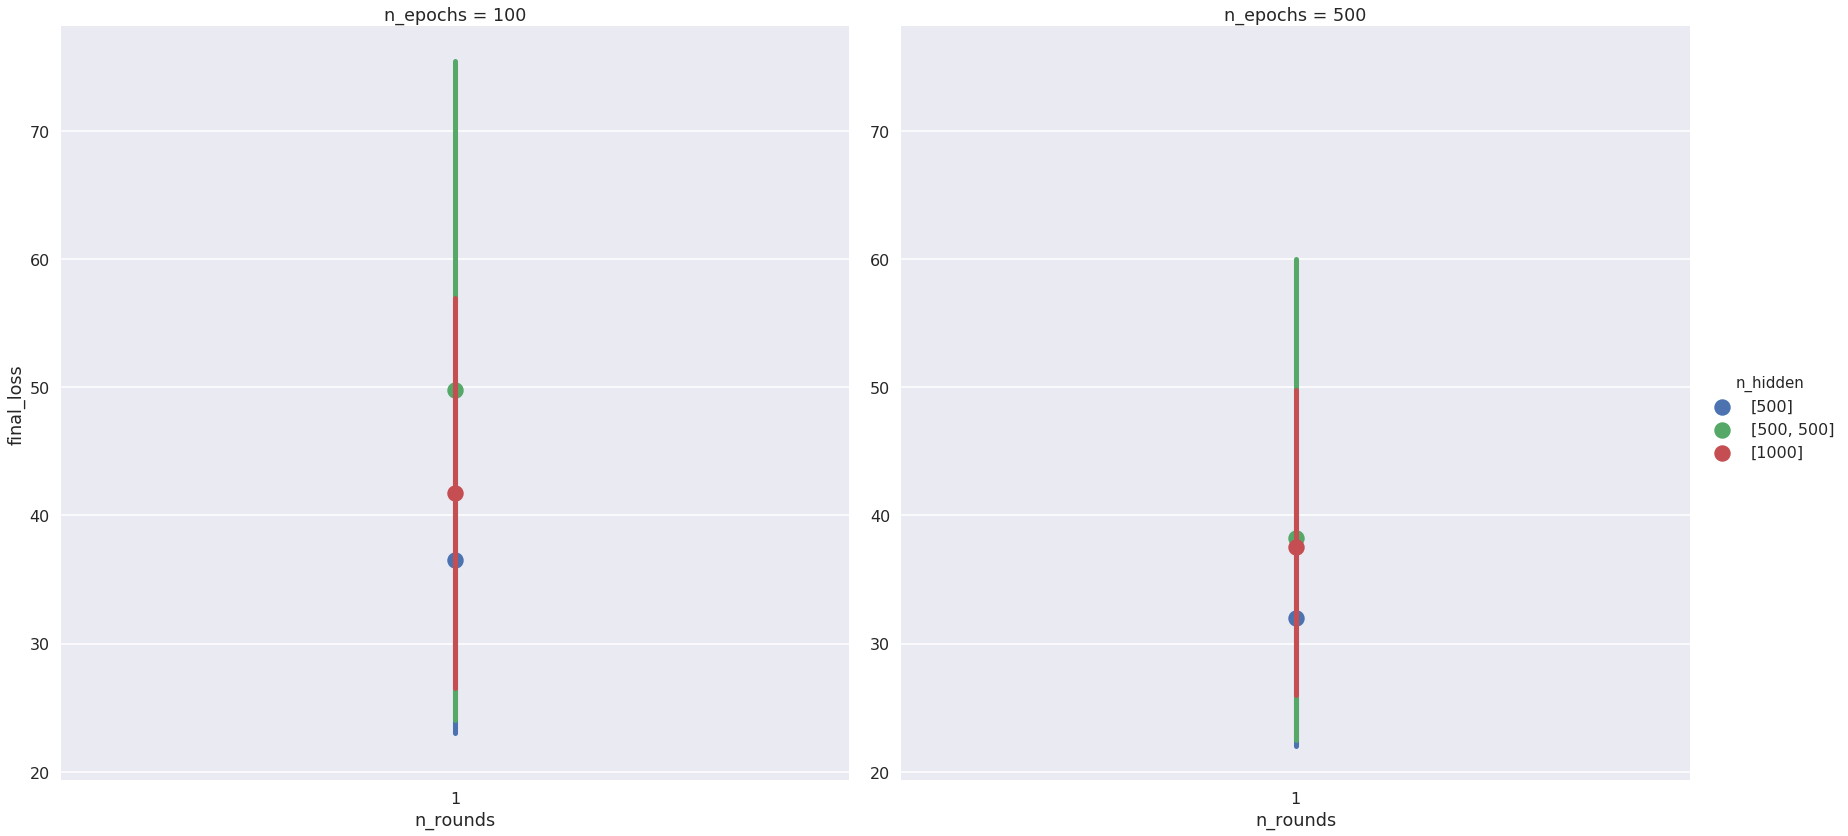

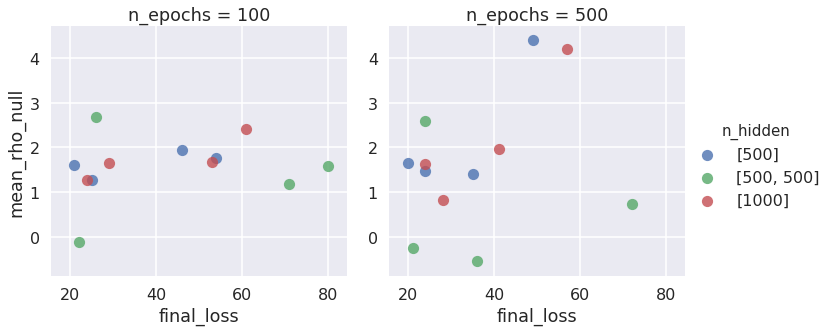

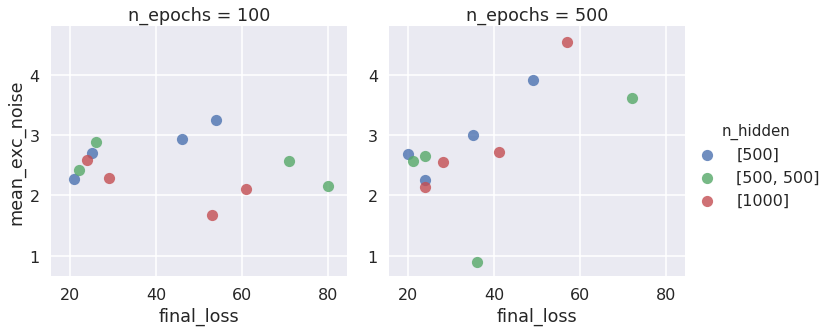

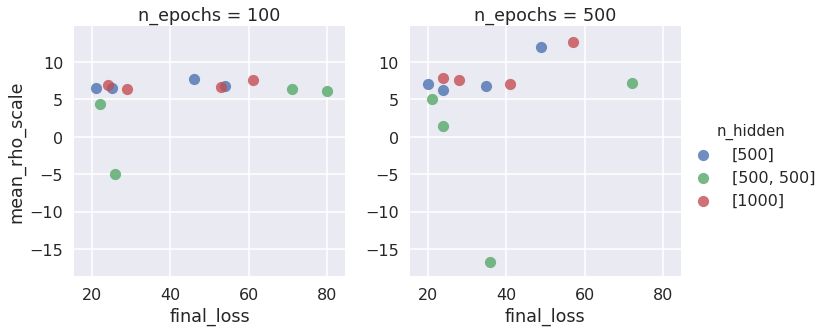

In [178]:
sns.set('poster')
sns.factorplot(x='n_train', y='mean_rho_scale', hue='n_hidden', col='n_epochs', kind='point', data=ffi_df, size=12)
sns.factorplot(x='n_train', y='std_rho_scale', hue='n_hidden', col='n_epochs', kind='point', data=ffi_df, size=12)
plt.ylim([0,10])
grid = sns.factorplot(x='n_train', y='final_loss', hue='n_hidden', col='n_epochs', kind='point', data=ffi_df, size=12)
grid = sns.factorplot(x='n_rounds', y='final_loss', hue='n_hidden', col='n_epochs', kind='point', data=ffi_df, size=12)
#grid.set(yscale='log')
grid = sns.lmplot(x='final_loss', y='mean_rho_null', hue='n_hidden', col='n_epochs', fit_reg=False, data=ffi_df)
grid = sns.lmplot(x='final_loss', y='mean_exc_noise', hue='n_hidden', col='n_epochs', fit_reg=False, data=ffi_df)
grid = sns.lmplot(x='final_loss', y='mean_rho_scale', hue='n_hidden', col='n_epochs', fit_reg=False, data=ffi_df)
#grid.set(yscale='log')

mean: [1.75395658 3.25148138 6.81625388]
mean: [ 4.3916129   3.90488757 11.97060655]
mean: [1.94982577 2.93061062 7.66609679]
mean: [1.39538401 3.00759823 6.74179844]
mean: [1.26212646 2.69938305 6.49145781]
mean: [1.48090082 2.25331477 6.26065804]
mean: [1.6094483  2.27087354 6.52922517]
mean: [1.65481924 2.69049099 6.9693683 ]


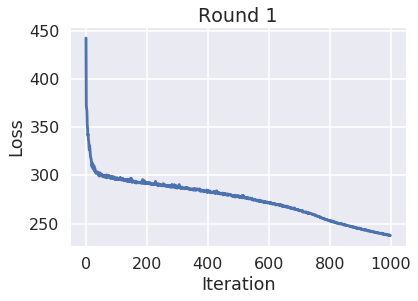

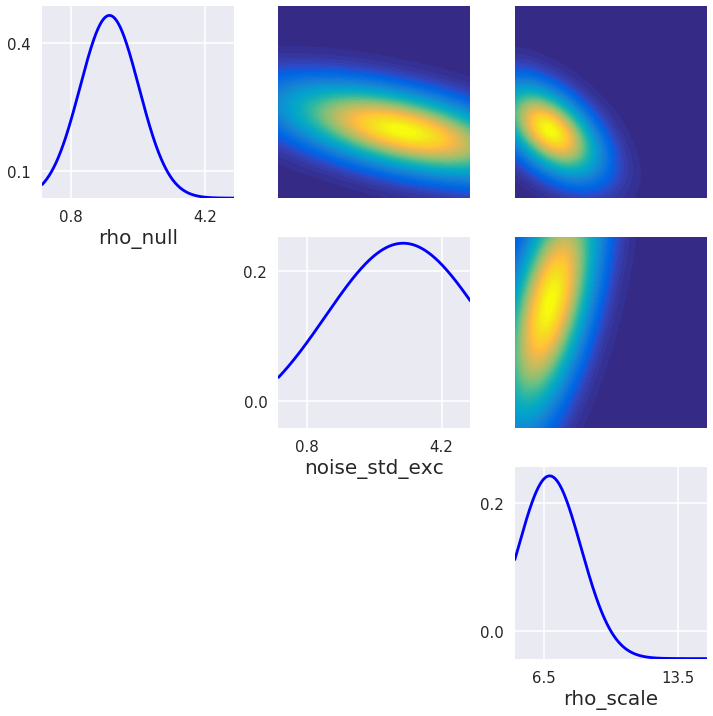

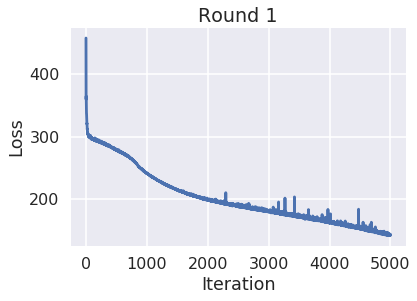

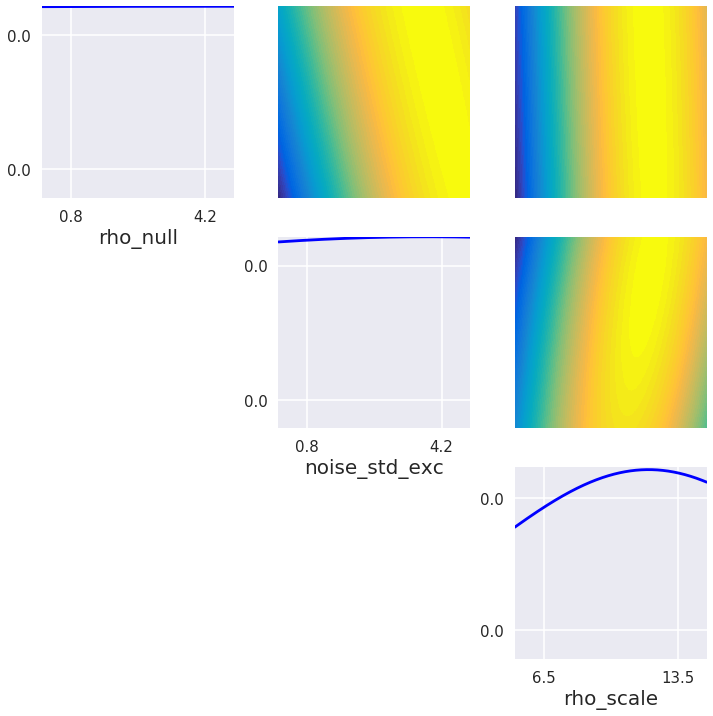

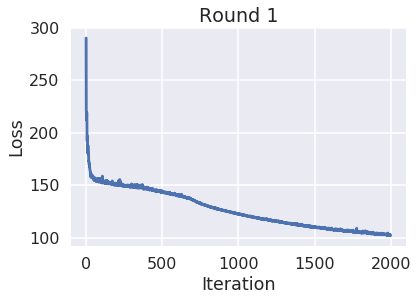

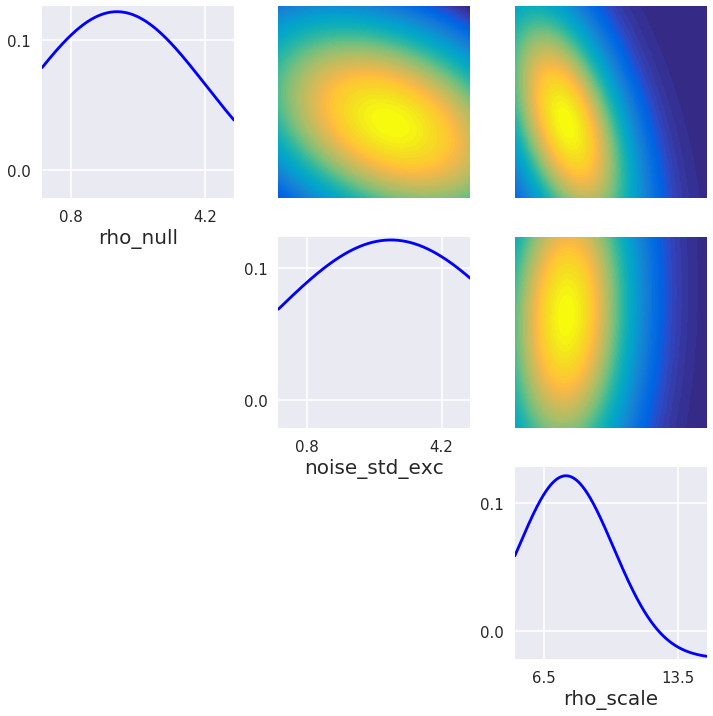

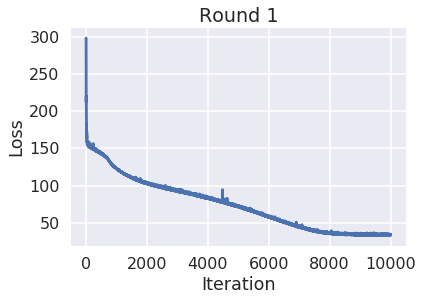

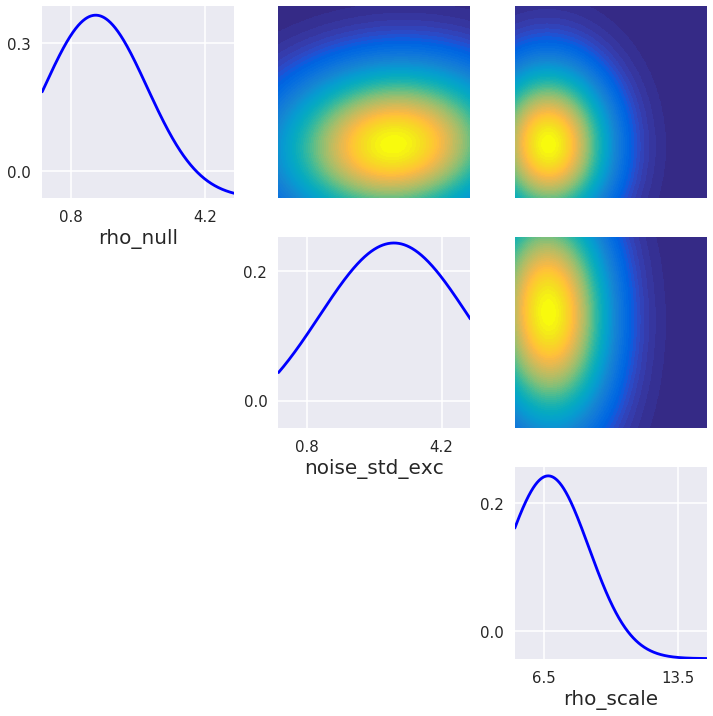

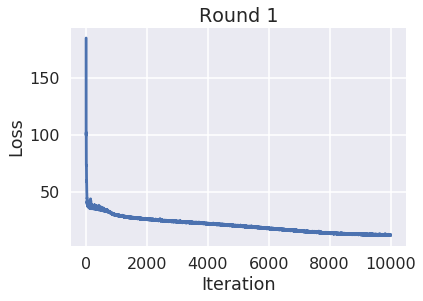

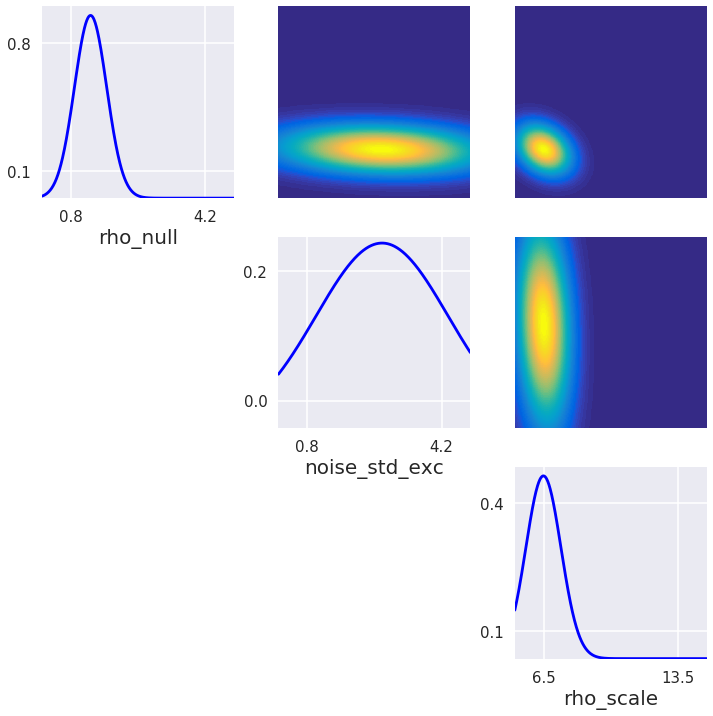

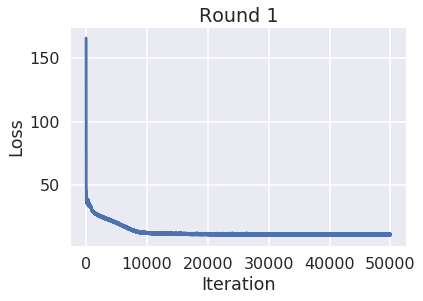

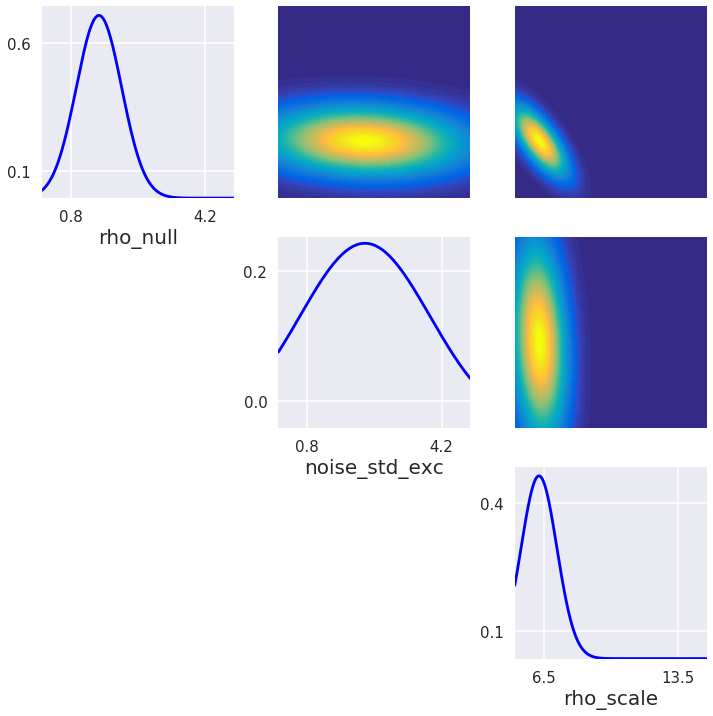

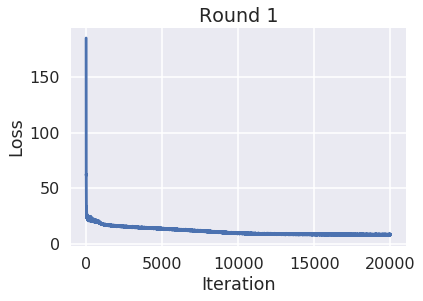

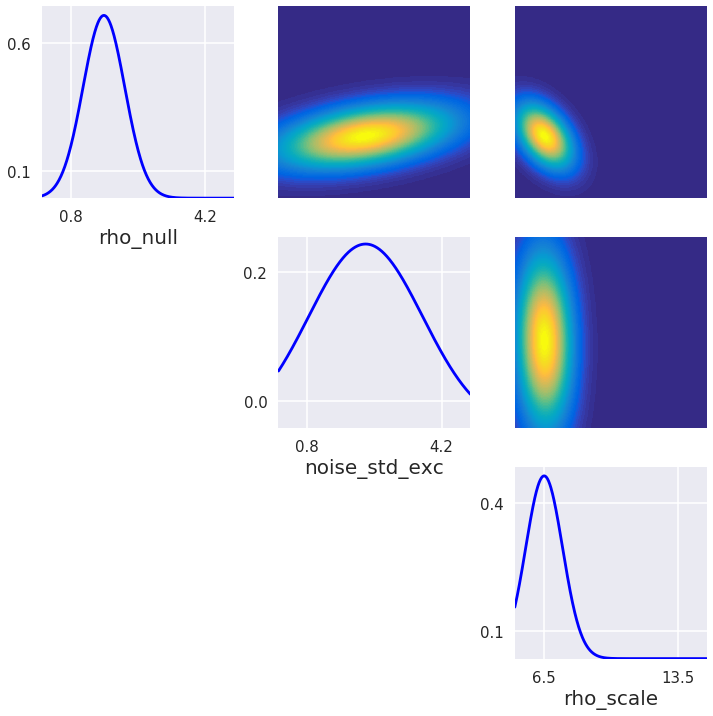

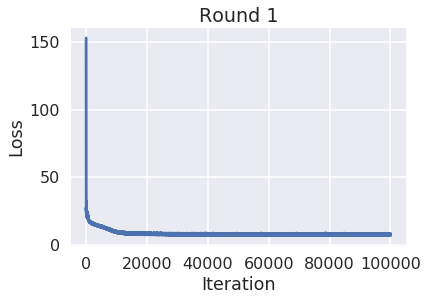

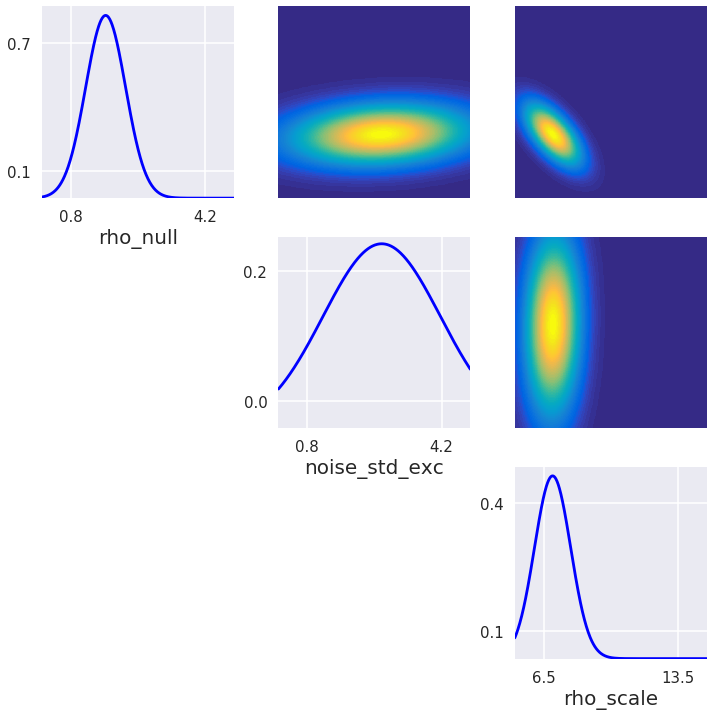

In [196]:
for i in range(4):
    for j in range(2):
        plot_ffi_fitting_results(ffi_logs_list[0][i][j], ffi_posterior_list[0][i][j])
        print('mean: ' + str(ffi_posterior_list[0][i][j].mean))

A Jupyter Widget

A Jupyter Widget

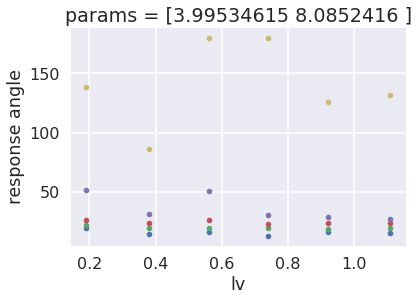

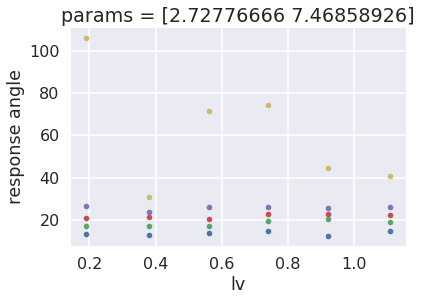

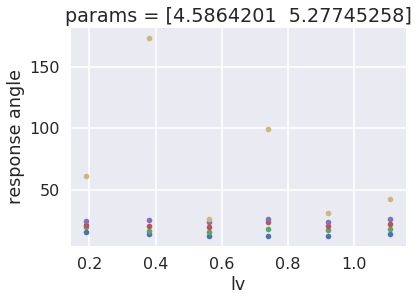

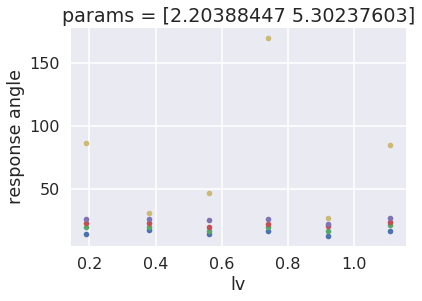

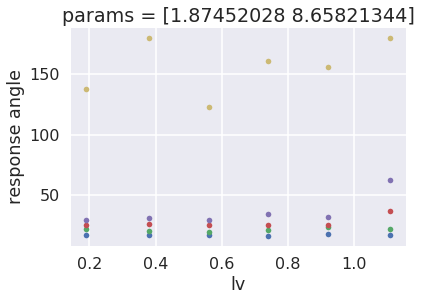

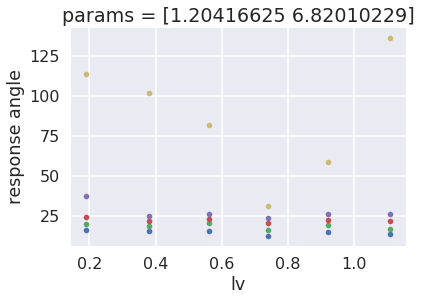

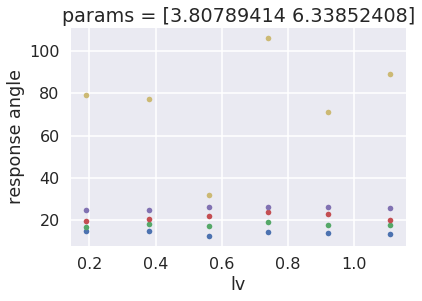

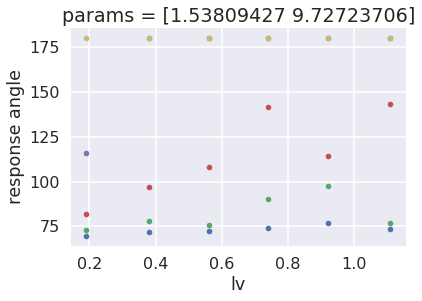

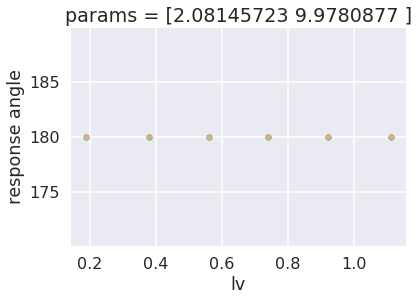

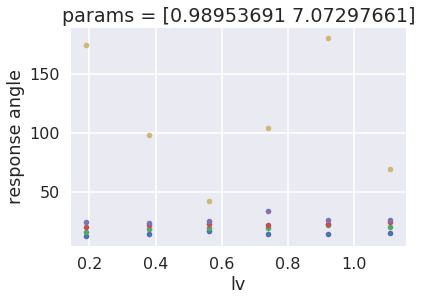

In [227]:
lv_centers = np.array([0.19, 0.38, 0.56, 0.74, 0.92, 1.11])
gparams, stats = g.gen(10)
for i in range(10):
    plt.figure()
    plt.plot(lv_centers, stats[i, :].reshape((6, 5)), '.')
    plt.ylabel(r'response angle')
    plt.xlabel(r'lv')
    plt.title('params = ' + str(gparams[i]))
    #print(stats[i, :])

In [232]:
for dat_idx in range(5):
    for i in range(3):
        gen_dat = stats[dat_idx][np.newaxis, :]
        print('current true parameter: ' + str(gparams[dat_idx]))
        pn_train = [3000]
        logs, posterior = run_fit_with(g, n_hiddens=[2000], n_train=pn_train, n_rounds=len(pn_train), epochs=500, data=gen_dat, seed=100)
        print('estimated parameter: ' + str(posterior.mean))
        plot_ffi_fitting_results(logs, posterior)
        lims = np.array([[0, 5], [5, 10]])
        viz.plot_pdf(posterior.xs[0], lims=lims, labels_params=['noise_std', 'rho_scale'], gt=gparams[dat_idx],
                     figsize=(12,12), ticks=True)

current true parameter: [3.99534615 8.0852416 ]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

KeyboardInterrupt: 

(<matplotlib.figure.Figure at 0x7f3544fc9dd8>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f353c284f98>,
       dtype=object))

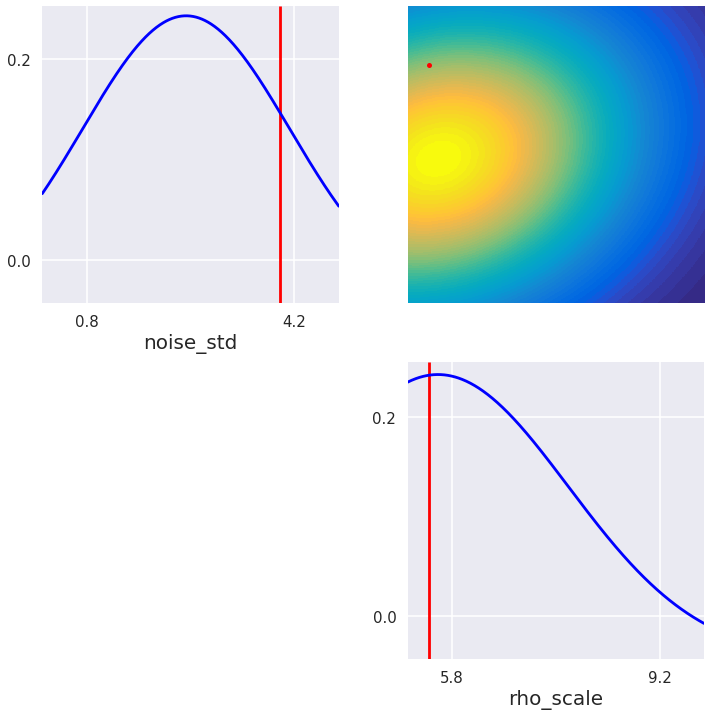

In [212]:
lims = np.array([[0, 5], [5, 10]])
viz.plot_pdf(posterior.xs[0], lims=lims, labels_params=['noise_std', 'rho_scale'], gt=gparams[1],
             figsize=(12,12), ticks=True)